










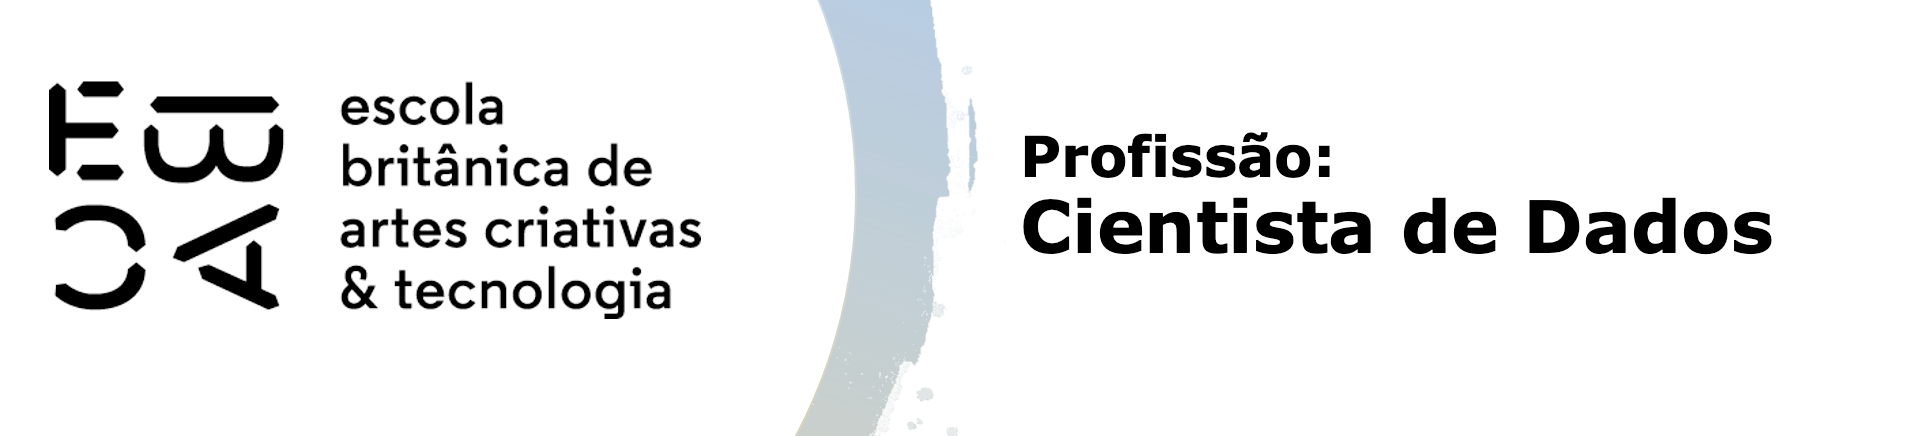

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [35]:
import pandas as pd
from pandas.api.types import is_object_dtype, is_bool_dtype, is_numeric_dtype

import numpy as np
from unidecode import unidecode

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLMResults

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from scipy.stats import ks_2samp, t, zscore, skew

In [2]:
#Função para análse univariada:

def distribuicao(df: pd.DataFrame, var: str, limite_discretas=40):
    '''
    Gera visualizações da distribuição de uma variável do DataFrame.

    - Variáveis categóricas ou booleanas: countplot.
    - Variáveis numéricas: histplot com boxplot.
    - Diferencia variáveis contínuas e discretas com base no número de valores únicos.

    Parâmetros:

    df : pd.DataFrame
        Conjunto de dados.
    var : str
        Nome da variável a ser analisada.
    limite_discretas : int, opcional
        Limite para considerar uma variável numérica como discreta (default=40).

    Retorna:

    Gráfico matplotlib.
    '''

    if var not in df.columns:
        raise ValueError(f'A variável {var} não está presente no DataFrame.')

    serie = df[var].copy()

    nulos = serie.isnull().sum()
    if nulos > 0:
        print(f'⚠️ A variável {var} contém {nulos} valores nulos. Eles serão ignorados.')
        serie = serie.dropna()

    plt.style.use('seaborn-v0_8-whitegrid')

    if is_object_dtype(serie) or is_bool_dtype(serie):
        fig, ax = plt.subplots(figsize=(10, 6))

        tipo = 'booleana' if is_bool_dtype(serie) else 'qualitativa'
        ordem = serie.value_counts().index
        
        sns.countplot(x=serie, hue=serie, palette='crest', order=ordem, legend=False, ax=ax)

        for container in ax.containers:
            ax.bar_label(container, fontsize=10)

        ax.set_title(f'Distribuição da variável {tipo}: {var.capitalize()}', fontsize=14)
        ax.set_ylabel('Contagem')
        ax.set_xlabel(var.capitalize())
        ax.grid(True, linestyle='--', alpha=0.5)
        
        contagem = serie.value_counts()
        porcentagem = (contagem / contagem.sum())
        porcentagem_format = porcentagem.apply(lambda x: f'{x:.2%}')
        print(f'Porcentagem por categoria: \n {porcentagem_format}')

    else:
        unicos = serie.nunique()
        tipo = 'discreta' if unicos <= limite_discretas else 'contínua'

        fig = plt.figure(figsize=(10, 6))
        gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), hspace=0.05)

        ax_box = fig.add_subplot(gs[0])
        ax_dist = fig.add_subplot(gs[1], sharex=ax_box)

        cor = sns.color_palette('crest')[2 if tipo == 'contínua' else 0]

        sns.boxplot(x=serie, ax=ax_box, color=cor)
        ax_box.set_ylabel('')
        ax_box.set_xlabel('')
        ax_box.set_title(f'Distribuição da variável {tipo}: {var}', fontsize=14)
        ax_box.grid(True, linestyle='--', alpha=0.5)
        ax_box.tick_params(bottom=False, labelbottom=False)

        if tipo == 'contínua':
            sns.histplot(serie, bins=30, ax=ax_dist, color=cor, edgecolor= None, kde=True)
        else:
            sns.countplot(x=serie, ax=ax_dist, color=cor)

        ax_dist.set_ylabel('Contagem')
        ax_dist.set_xlabel(var.capitalize())
        ax_dist.grid(True, linestyle='--', alpha=0.5)

    plt.show()
    
    
# Função para analise bivariada:

def bivar (df: pd.DataFrame, var: str, limite_discretas=40):
    '''
    Gera visualizações da distribuição da inadimplência para uma variável do DataFrame.

    - Variáveis categóricas ou booleanas: barplot.
    - Variáveis numéricas: histplot.
    - Diferencia variáveis contínuas e discretas com base no número de valores únicos.

    Parâmetros:

    df : pd.DataFrame
        Conjunto de dados.
    var : str
        Nome da variável a ser analisada.
    limite_discretas : int, opcional
        Limite para considerar uma variável numérica como discreta (default=40).

    Retorna:

    Gráfico matplotlib.
    '''
    
    if var not in df.columns:
        raise ValueError(f'A variável {var} não está presente no DataFrame.')
    elif var == 'mau':
        raise ValueError(f'A variável {var} é a variável resposta, não pode ser utilizada.')
    
    serie = df[[var, 'mau']].copy()

    nulos = serie[var].isnull().sum()
    
    if nulos > 0:
        print(f'⚠️ A variável {var} contém {nulos} valores nulos. Eles serão ignorados.\n')
        serie = serie.dropna()

    plt.style.use('seaborn-v0_8-whitegrid')
    
    if is_object_dtype(serie[var]) or is_bool_dtype(serie[var]):
        
        rotation = 30 if var == 'mes' else 0
        
        prop = serie.groupby([var, 'mau']).size().unstack(fill_value=0)
        prop.columns = ['Adimplentes', 'Inadimplentes']
        prop_percentual = prop.div(prop.sum(axis=1), axis=0)
        prop_formatado = prop_percentual.map(lambda x: f'{x:.2%}')

        print(prop_formatado)
        
        plt.figure(figsize=(10,6))
        
        grb = serie.groupby(['mau', var]).size().reset_index(name='quantidade')
        grb['mau'] = grb['mau'].map({True: 'Inadimplente', False: 'Adimplente'})

        ax = sns.barplot(
                        data=grb,
                        hue='mau',
                        x=var,
                        y='quantidade',
                        palette='crest'
                        )
        
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
            
        ax.set_title(f'Distribuição inadimplência em função de {var}', fontsize=14)
        ax.set_ylabel('Quantidade')
        ax.set_xlabel(f'{var.capitalize()}', labelpad=20)
        ax.tick_params(axis='x', rotation=rotation)
        ax.grid(True, linestyle='--', alpha=0.5, axis='y')
        ax.legend(title='Inadimplência', loc='upper right', bbox_to_anchor=(1.2, 0.95))
                
    else: 
        
        serie['mau'] = serie['mau'].map({True: 'Inadimplente', False: 'Adimplente'})
        
        medio = serie.groupby('mau')[var].mean().reset_index(name=f'media_{var}')
        print(medio.round(2))
        
        unicos = serie[var].nunique()
        tipo = True if unicos <= limite_discretas else False
        kde = False if unicos <= limite_discretas else True
        
        plt.figure(figsize=(10,6))
        
        ax = sns.histplot(
                          data=serie,
                          hue='mau',
                          x=var,
                          discrete=tipo,
                          palette='crest',
                          bins=40,
                          edgecolor= None, 
                          kde=kde
        )
        
        classes = serie['mau'].unique()
        cores = sns.color_palette('crest', n_colors=len(classes))
        handles = [Patch(facecolor=cores[i], label=classe) for i, classe in enumerate(classes)]
        
        ax.set_title(f'Distribuição inadimplência em função de {var}', fontsize=14)
        ax.set_ylabel('Quantidade')
        ax.set_xlabel(f'{var.capitalize()}', labelpad=20)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(handles=handles, title='Inadimplência', loc='upper right', bbox_to_anchor=(1.2, 0.95))
        
    plt.show()
    
    
# Função para tratamento dos outliers das variáveis:

def cap_outliers_iqr(data: pd.DataFrame, col: str) -> pd.DataFrame:
    '''
    Remove outliers de uma coluna numérica com base na regra do intervalo interquartílico (IQR).

    Parâmetros:
    - data (pd.DataFrame): O DataFrame com os dados.
    - col (str): O nome da coluna a ser avaliada.

    O método calcula o primeiro (Q1) e o terceiro quartil (Q3) da variável, define os limites inferior e superior como:
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

    Observações:
    - Valores fora desse intervalo são considerados outliers e serão removidos.
    - A aplicação da regra após uma transformação logarítmica pode reduzir o impacto de valores extremos muito altos.
    '''
    
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    data[col] = data[col].clip(lower=limite_inferior, upper=limite_superior)
    return data


# Função para visualização dos outliers a serem tratados:

def box_outlier(df: pd.DataFrame):
    '''
    Gera boxplots para variáveis numéricas do DataFrame.

    Essa função tem como objetivo visualizar a distribuição e possíveis outliers das variáveis numéricas
    de um DataFrame por meio de gráficos do tipo boxplot.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo os dados a serem analisados.

    Comportamento:
    - Seleciona automaticamente as colunas numéricas do tipo float64 ou int64, excluindo 'index' e 'renda'.
    - Cria um gráfico de boxplot individual para cada uma dessas variáveis.
    - Os gráficos são dispostos em um grid de 3 linhas por 2 colunas, com título e grade no eixo y.

    Observações:
    - A função apenas exibe os gráficos, não retorna valores nem altera o DataFrame original.
    '''
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['index', 'renda']).columns

    plt.figure(figsize=(10,10))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(3,2,i)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot da variável {col}', fontsize=10)
        plt.tight_layout()
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Função para avaliação do WOE das variáveis discretas:

def woe_discreta(df: pd.DataFrame, var: str):
    '''
    Calcula e plota o Weight of Evidence (WOE) para uma variável categórica discreta e sua evolução ao longo do tempo.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo as colunas 'mau', 'mes' e a variável categórica de interesse.
    - var (str): Nome da variável categórica a ser analisada.

    Descrição:
    - A função agrupa os dados pela variável categórica e calcula:
        - Quantidade de bons (1 - mau) e maus (mau)
        - Taxa de mau e erro padrão
        - Intervalo de confiança da taxa de mau usando distribuição t-student
        - Logit da taxa de mau e intervalo
        - WOE por categoria em relação à taxa média de mau da base
        
    Retorno:
    - pd.DataFrame: Tabela com estatísticas por categoria da variável, incluindo:
        - Quantidade de bons e maus
        - Taxa de mau
        - Intervalo de confiança da taxa de mau
        - Logit (log da odds)
        - WOE (Weight of Evidence)
        - Intervalo de confiança do WOE

    - Também são gerados 3 gráficos:
        1. WOE com intervalo de confiança para cada categoria
        2. Evolução temporal do WOE por categoria (por mês)
        3. Gráfico de barras com a contagem de observações por categoria

    Observações:
    - A ordenação das categorias segue o WOE, exceto para variáveis específicas como 'qtd_filhos' ou 'qt_pessoas_residencia'.
    - O gráfico temporal exige a existência da coluna 'mes' no DataFrame para análise por período.
    '''
    
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral
    biv = biv if var in ['qtd_filhos', 'qt_pessoas_residencia'] else biv.sort_values(by='woe', ascending=False)
    ordem_categorias = biv[var].tolist()

    fig, ax = plt.subplots(3,1, figsize=(10,12))
    plt.subplots_adjust(hspace=0.25)
    
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var])
    ax[0].grid(True, linestyle='--', alpha=0.5)

    grouped = df.groupby(['mes', var]).agg({'mau': 'mean'}).reset_index()
    grouped['woe'] = np.log(grouped['mau'] / (1 - grouped['mau'])) - woe_geral

    sns.lineplot(data=grouped, x='mes', y='woe', hue=var, ax=ax[1], marker='o', linestyle=':')
    ax[1].set_ylabel("Evolução do WOE")
    ax[1].set_xlabel('')
    ax[1].tick_params(axis='x', rotation=30)
    ax[1].legend(title=None)
    ax[1].grid(True, linestyle='--', alpha=0.5)
       
    sns.countplot(data=df, x=var, hue=var, order=ordem_categorias, palette='crest', legend=False, ax=ax[2])

    for container in ax[2].containers:
        ax[2].bar_label(container, fontsize=10)

    ax[2].set_ylabel(f'Contagem por {var}')
    ax[2].set_xlabel(f'{var.capitalize()}', labelpad=20)
    ax[2].grid(True, linestyle='--', alpha=0.5)

    return biv


# Função para avaliação do WOE das variáveis contínuas 

def woe_continua(df: pd.DataFrame, var: str, ncat: int):
    '''
    Calcula e plota o Weight of Evidence (WoE) para uma variável contínua categorizada em quantis.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo as colunas 'mau', 'mes' e a variável contínua de interesse.
    - var (str): Nome da variável contínua a ser analisada.
    - ncat (int): Número de categorias (bins) que a variável contínua será dividida usando quantis.

    Descrição:
    - Divide a variável contínua `var` em `ncat` categorias utilizando cortes por quantis (`qcut`).
    - Agrupa os dados pelas categorias criadas e calcula:
        - Quantidade de bons (1 - mau) e maus (mau)
        - Taxa de mau e erro padrão
        - Intervalo de confiança da taxa de mau usando distribuição t-student
        - Logit da taxa de mau e intervalo
        - WOE por categoria em relação à taxa média de mau da base
        
    - Plota três gráficos em uma figura:
        1. WOE com intervalo de confiança para cada categoria criada.
        2. Evolução temporal do WOE por categoria (por mês).
        3. Contagem de observações por categoria da variável.

    Retorno:

    None
        A função retorna None, mas exibe uma figura com três subplots mostrando o WoE e contagens.
        
    Observações:
    - O cálculo do intervalo de confiança para a taxa de 'mau' e WoE é baseado na distribuição t.
    - O gráfico temporal exige a existência da coluna 'mes' no DataFrame para análise por período.
    '''
    
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs, observed=False)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(3,1, figsize=(10,12))
    plt.subplots_adjust(hspace=0.25)

    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    ax[0].grid(True, linestyle='--', alpha=0.5)
    
    grouped = df.groupby(['mes']).agg({'tempo_emprego': 'mean', 'mau': 'mean'}).reset_index()
    grouped['woe'] = np.log(grouped['mau'] / (1 - grouped['mau'])) - woe_geral

    sns.lineplot(data=grouped, x='mes', y='woe', ax=ax[1], marker='o', linestyle=':')
    ax[1].set_ylabel('Evolução do WOE')
    ax[1].set_xlabel('')
    ax[1].tick_params(axis='x', rotation=30)
    ax[1].grid(True, linestyle='--', alpha=0.5)
    
    ax[2] = biv.cont.plot.bar()
    ax[2].set_ylabel(f'Contagem por {var}')
    ax[2].set_xlabel(f'{var.capitalize()}', labelpad=20)
    ax[2].grid(True, linestyle='--', alpha=0.5)
    
    return None


# Função para o cálculo do Information Value de cada variável:

def IV(df: pd.DataFrame, feature: str, target: str, limiar_qcut=10) -> float:
    '''
    Calcula o Information Value (IV) de uma variável explicativa em relação a uma variável target binária.

    O Information Value é uma métrica usada para medir a capacidade preditiva de uma variável explicativa 
    em problemas de classificação binária, sendo muito utilizada em análise de crédito e modelagem de risco.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo os dados da variável explicativa e target.
    - feature (str): Nome da variável explicativa para a qual será calculado o IV.
    - target (str): Nome da variável target binária (deve conter apenas duas classes).
    - limiar_qcut (10, opcional): Limiar para categorização de variáveis com mais de 10 valores únicos (padrão: 10).
    
    Descrição:
    - Recebe um DataFrame com a variável explicativa (`feature`) e a variável target binária (`target`).
    - Se a variável explicativa for numérica e possuir mais de 10 valores únicos, ela é categorizada em 10 bins por quantis.
    - Calcula a tabela cruzada de frequências entre as categorias de `feature` e as classes de `target`.
    - Aplica um ajuste para evitar divisão por zero somando 0.0001 às frequências.
    - Calcula o Weight of Evidence (WoE) para cada categoria.
    - Calcula e retorna o Information Value (IV) agregando o impacto das categorias.

    Retorno:
    - float: Contendo o valor do Information Value para a variável `feature`.

    Observações:
    - A variável target deve ser binária, com duas classes distintas.
    - O valor do IV pode ser usado para avaliar a força preditiva da variável:
      * IV < 0.02: sem poder preditivo
      * 0.02 <= IV < 0.1: fraco
      * 0.1 <= IV < 0.3: médio
      * 0.3 <= IV < 0.5: forte
      * IV >= 0.5: muito forte
    - A discretização é feita automaticamente para variáveis numéricas com mais de 10 valores únicos,
      mas pode ser ajustada conforme a necessidade.
    '''
    
    df_temp = df[[feature, target]].copy()

    if pd.api.types.is_numeric_dtype(df_temp[feature]):
        num_unique = df_temp[feature].nunique()
    
        if num_unique > limiar_qcut:
            try:
                df_temp[feature] = pd.qcut(df_temp[feature], q=10, duplicates='drop')
            except:
                pass
    
    tab = pd.crosstab(df_temp[feature], df_temp[target])
    tab = tab + 0.0001

    col_evento, col_nao_evento = tab.columns[1], tab.columns[0]

    pct_evento = tab[col_evento] / tab[col_evento].sum()
    pct_nao_evento = tab[col_nao_evento] / tab[col_nao_evento].sum()

    woe = np.log(pct_evento / pct_nao_evento)
    iv = np.sum((pct_evento - pct_nao_evento) * woe)

    return iv

# Função para comparar metricas dos modelos:

def comparar_modelos(modelos_dict: dict, df_teste: pd.DataFrame, y_col='mau', cutoff=0.5) -> pd.DataFrame:
    '''
    Compara o desempenho de múltiplos modelos classificadores usando métricas comuns.

    Parâmetros:
    - modelos_dict (dict): Dicionário com pares {nome_modelo: objeto_modelo}, 
    onde cada modelo deve implementar os métodos/atributos: predict, deviance, null_deviance, aic.
    - df_teste (pd.DataFrame): DataFrame contendo os dados de teste, incluindo a variável target `y_col`.
    - y_col (str, opcional): Nome da coluna da variável target no DataFrame de teste (padrão: 'mau').
    - cutoff (float, opcional): Limite de corte para converter probabilidades em predições binárias (padrão: 0.5).

    Descrição:
    Para cada modelo no dicionário `modelos_dict`, a função:
    - Calcula as probabilidades previstas (`predict`) sobre o conjunto de teste `df_teste`.
    - Gera predições binárias a partir do cutoff definido (default 0.5).
    - Calcula as seguintes métricas:
        * AIC (Akaike Information Criterion)
        * Pseudo R² (1 - deviance/null deviance)
        * AUC (Área sob a curva ROC)
        * KS (Kolmogorov-Smirnov)
        * Gini (2 * AUC - 1)
        * Acurácia (accuracy)
    - Agrupa os resultados em um DataFrame formatado e ordenado pela acurácia decrescente.

    Retorno:
    
    - pd.DataFrame.style: DataFrame formatado com as métricas para cada modelo, ordenado pela acurácia.

    Observações:
    - Os modelos devem suportar o método `predict` que retorna probabilidades.
    - O KS é calculado usando a estatística do teste Kolmogorov-Smirnov entre scores das classes.
    - O DataFrame retornado é estilizado para exibir porcentagens nas métricas relevantes.
    '''
    
    resultados = []

    for nome, modelo in modelos_dict.items():

        probas = modelo.predict(df_teste)
        preds = (probas > cutoff).astype(int)
        df_teste = df_teste.copy()
        df_teste['score'] = probas
 
        auc = roc_auc_score(df_teste[y_col], probas)
        acc = accuracy_score(df_teste[y_col], preds)
        pseudo_r2 = 1 - modelo.deviance / modelo.null_deviance
        ks = ks_2samp(df_teste.loc[df_teste[y_col] == 1, 'score'],
                      df_teste.loc[df_teste[y_col] == 0, 'score']).statistic
        gini = 2 * auc - 1

        resultados.append({
            "Modelo": nome,
            "AIC": modelo.aic,
            "Pseudo R²": pseudo_r2,
            "AUC": auc,
            "KS": ks,
            "Gini": gini,
            "Acurácia": acc
        })
    
    comp = pd.DataFrame(resultados).sort_values(by="Acurácia", ascending=False)
    comp = comp.set_index('Modelo').style.format({'Pseudo R²':'{:.2%}', 'AUC':'{:.2%}', 'KS':'{:.2%}', 'Gini':'{:.2%}', 'Acurácia':'{:.2%}'})
    return comp

# Função avaliar modelo: 

def avaliar_modelo(modelo: GLMResults, df_teste: pd.DataFrame, y_col='mau', cutoff=0.5, nome_modelo='Modelo') -> pd.DataFrame:
    '''
    Avalia o desempenho de um modelo GLM (Generalized Linear Model) em um conjunto de teste, calculando várias métricas.

    Parâmetros:
    - modelo (GLMResults): Objeto modelo treinado (resultado de um GLM do statsmodels) que deve conter os atributos 
    `predict()`, `aic`, `deviance` e `null_deviance`.
    - df_teste (pd.DataFrame): DataFrame contendo os dados de teste, incluindo a variável target `y_col`.
    - y_col (str, opcional): Nome da coluna da variável target no DataFrame de teste (padrão: 'mau').
    - cutoff (float, opcional): Limite de corte para converter probabilidades em predições binárias (padrão: 0.5).
    - nome_modelo (str, opcional): Nome do modelo para ser usado como índice no DataFrame resultado (padrão: 'Modelo').

    Descrição:
    - Calcula as probabilidades previstas (`predict`) pelo modelo para os dados de teste.
    - Gera predições binárias a partir de um cutoff definido (padrão 0.5).
    - Calcula as seguintes métricas de desempenho:
        * AIC (Akaike Information Criterion)
        * Pseudo R² (1 - deviance/null deviance)
        * AUC (Área sob a curva ROC)
        * KS (Kolmogorov-Smirnov)
        * Gini (2 * AUC - 1)
        * Acurácia (accuracy)
    - Retorna um DataFrame transposto contendo essas métricas, indexado pelo nome do modelo.

    Retorno:
    - pd.DataFrame: DataFrame transposto contendo as métricas calculadas, indexado pelo nome do modelo.

    Observações:
    - A função faz uma cópia do DataFrame de teste para evitar modificações no original.
    - O DataFrame retornado possui as métricas como índice e o nome do modelo como coluna.
    '''
    
    probas = modelo.predict(df_teste)
    preds = (probas > cutoff).astype(int)
    
    df_teste = df_teste.copy()
    df_teste['score'] = probas

    auc = roc_auc_score(df_teste[y_col], probas)
    acc = accuracy_score(df_teste[y_col], preds)
    pseudo_r2 = 1 - modelo.deviance / modelo.null_deviance
    ks = ks_2samp(df_teste.loc[df_teste[y_col] == 1, 'score'],
                  df_teste.loc[df_teste[y_col] == 0, 'score']).statistic
    gini = 2 * auc - 1

    resultados = {
        "Modelo": nome_modelo,
        "AIC": modelo.aic,
        "Pseudo R²": pseudo_r2,
        "AUC": auc,
        "KS": ks,
        "Gini": gini,
        "Acurácia": acc
    }
    result = pd.DataFrame([resultados])
    result = result.set_index('Modelo')
    return result.T

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
data_final = df.data_ref.max()
data_inicio = data_final - pd.DateOffset(months=3)

validacao = df[df.data_ref >= data_inicio]
treino = df[df.data_ref < data_inicio]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
df['posse_de_veiculo'] = df['posse_de_veiculo'].map({'S': True, 'N': False})
df['posse_de_imovel'] = df['posse_de_imovel'].map({'S': True, 'N': False})

In [6]:
print(f'Número de linhas: {df.shape[0]} \nNúmero de colunas: {df.shape[1]}')

Número de linhas: 750000 
Número de colunas: 15


In [7]:
df['mes'] = pd.to_datetime(df['data_ref']).dt.to_period('M')
df['mes'] = df.mes.astype(str)

contagem_safra = df.groupby('mes').size().reset_index(name='contagem')
contagem_safra

mes  contagem
0   2015-01     50000
1   2015-02     50000
2   2015-03     50000
3   2015-04     50000
4   2015-05     50000
5   2015-06     50000
6   2015-07     50000
7   2015-08     50000
8   2015-09     50000
9   2015-10     50000
10  2015-11     50000
11  2015-12     50000
12  2016-01     50000
13  2016-02     50000
14  2016-03     50000

Sexo:

Porcentagem por categoria: 
 sexo
F    67.28%
M    32.72%
Name: count, dtype: object


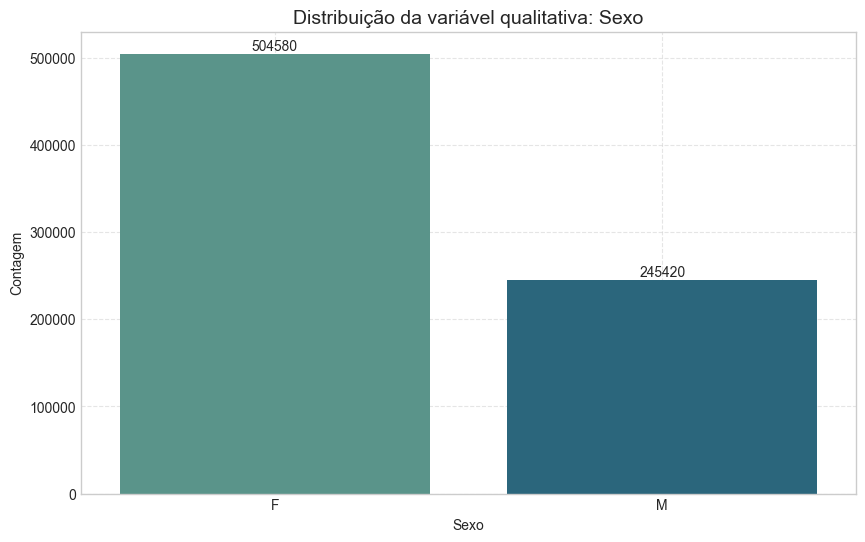

In [8]:
distribuicao(df, 'sexo')

Posse de veículo:

Porcentagem por categoria: 
 posse_de_veiculo
False    61.06%
True     38.94%
Name: count, dtype: object


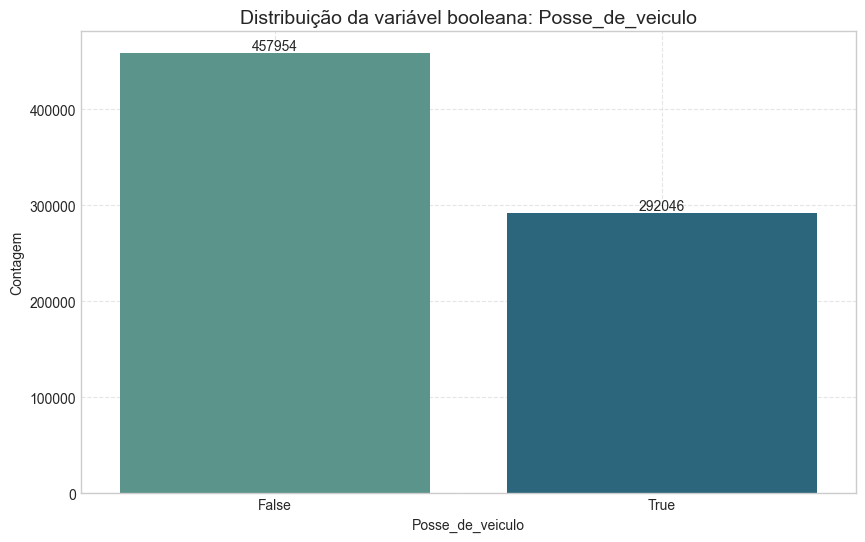

In [9]:
distribuicao(df, 'posse_de_veiculo')

Posse de imóvel:

Porcentagem por categoria: 
 posse_de_imovel
True     67.16%
False    32.84%
Name: count, dtype: object


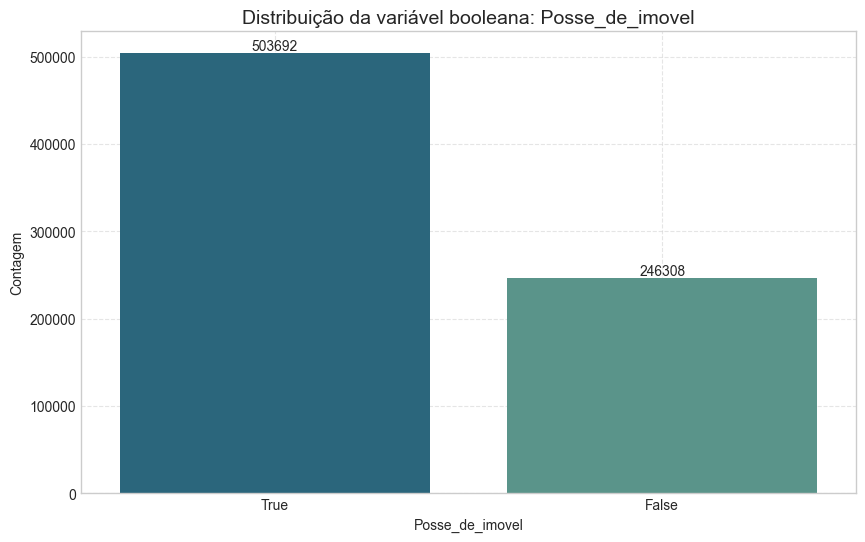

In [10]:
distribuicao(df, 'posse_de_imovel')

Quantidade de filhos:

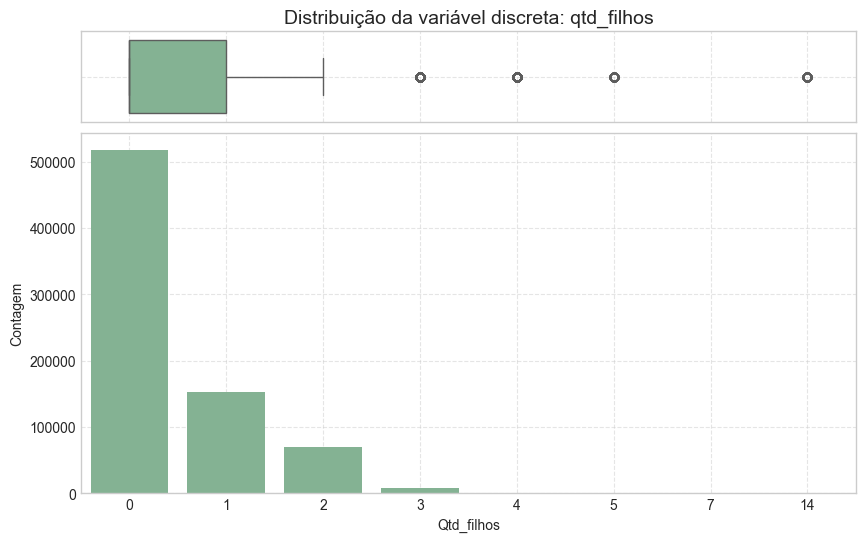

In [11]:
distribuicao(df, 'qtd_filhos')

Tipo de renda:

Porcentagem por categoria: 
 tipo_renda
Assalariado         51.43%
Empresário          23.03%
Pensionista         16.84%
Servidor público     8.66%
Bolsista             0.05%
Name: count, dtype: object


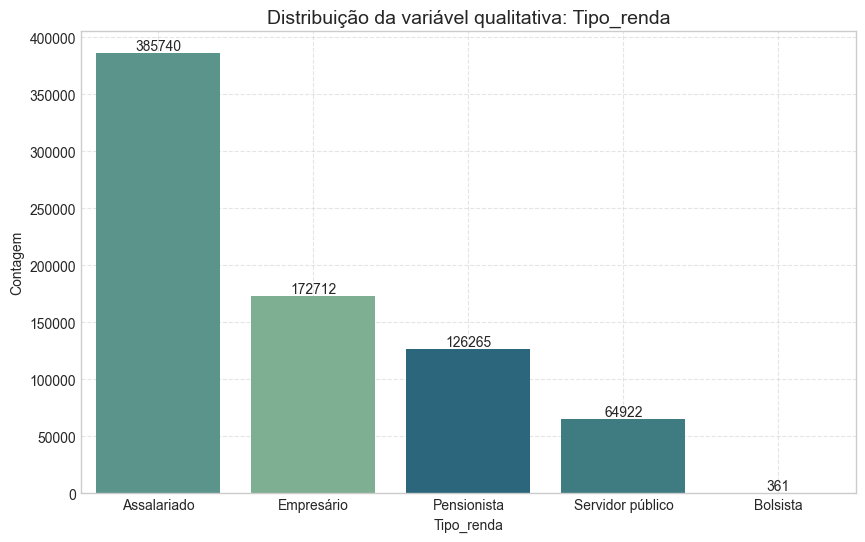

In [12]:
distribuicao(df, 'tipo_renda')

Nível de educação:

Porcentagem por categoria: 
 educacao
Médio                  67.58%
Superior completo      27.24%
Superior incompleto     3.93%
Fundamental             1.14%
Pós graduação           0.11%
Name: count, dtype: object


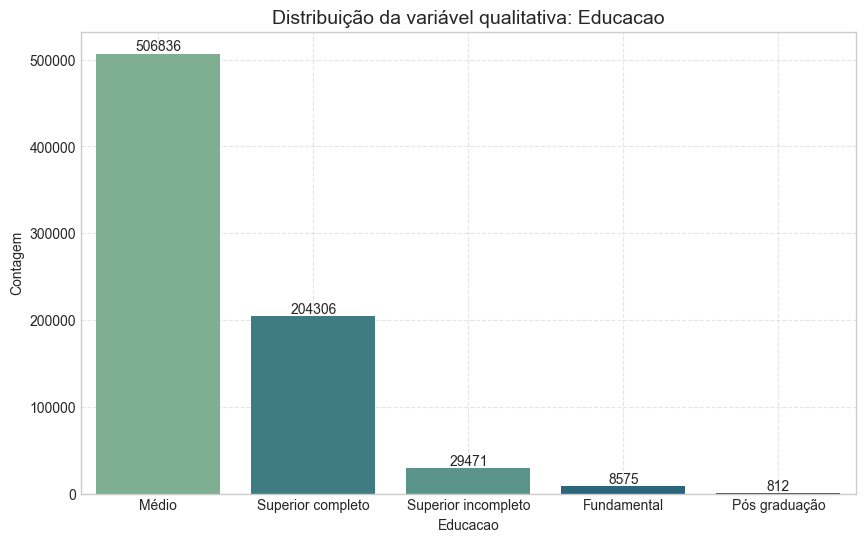

In [13]:
distribuicao(df, 'educacao')

Estado civil:

Porcentagem por categoria: 
 estado_civil
Casado      70.20%
Solteiro    12.22%
União        7.69%
Separado     5.68%
Viúvo        4.22%
Name: count, dtype: object


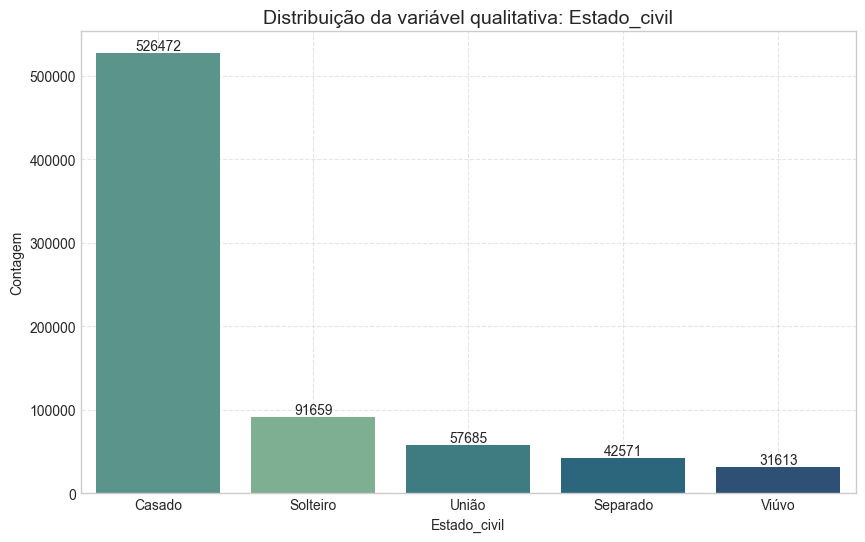

In [14]:
distribuicao(df, 'estado_civil')

Tipo de residência:

Porcentagem por categoria: 
 tipo_residencia
Casa             89.91%
Com os pais       4.43%
Governamental     3.13%
Aluguel           1.38%
Estúdio           0.72%
Comunitário       0.44%
Name: count, dtype: object


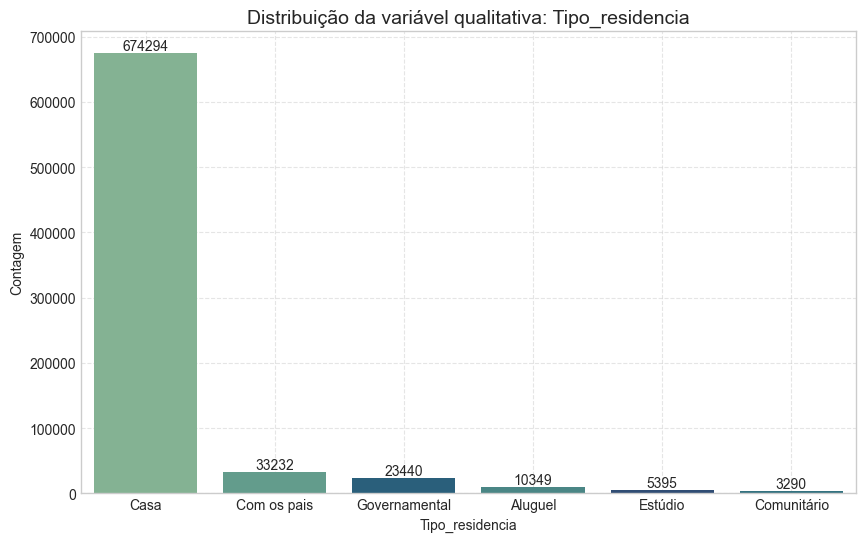

In [15]:
distribuicao(df, 'tipo_residencia')

Idade:

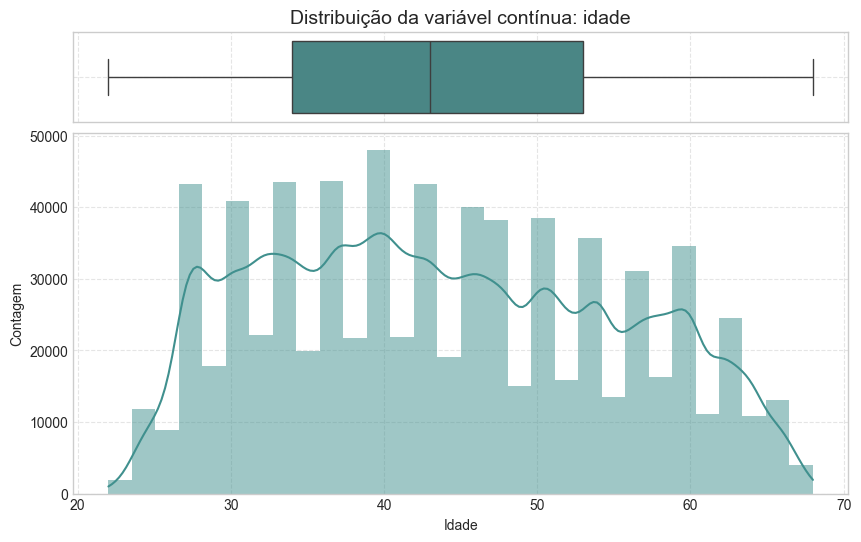

In [16]:
distribuicao(df, 'idade')

Tempo de emprego:

⚠️ A variável tempo_emprego contém 125957 valores nulos. Eles serão ignorados.


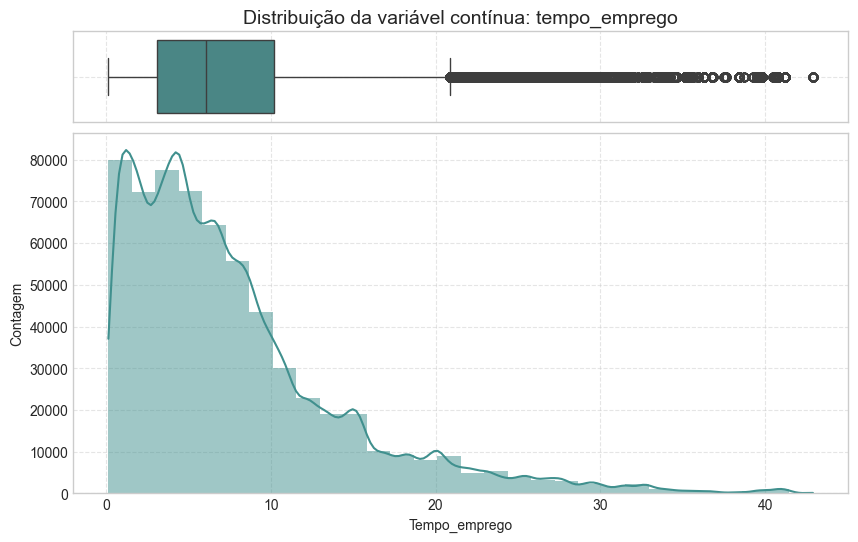

In [17]:
distribuicao(df, 'tempo_emprego')

Quantidade de pessoas na residência:

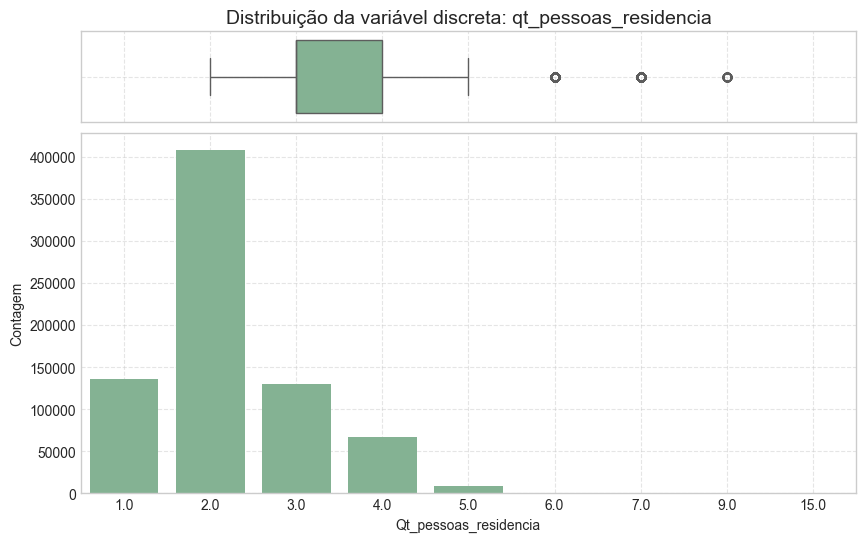

In [18]:
distribuicao(df, 'qt_pessoas_residencia')

Renda:

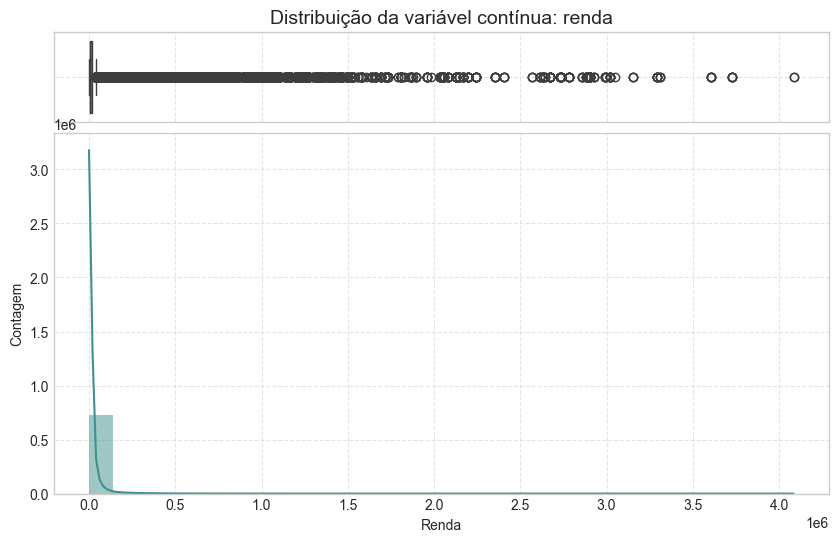

In [19]:
distribuicao(df, 'renda')

A variável `renda` possui skweness acentuado, ou seja uma longa cauda para a direita. O que indica que a mesma possui característica de distribuição logarítmica. Para fins de modelagem e para aproximá-la da normal será criada a variável `log_renda`.

Log da renda:

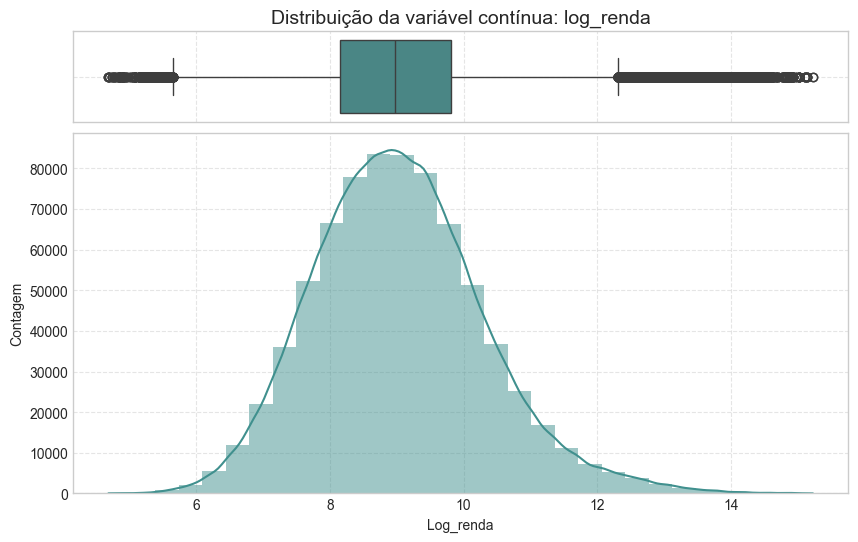

In [20]:
df['log_renda'] = np.log1p(df['renda'])
distribuicao(df, 'log_renda')

Mau:

Porcentagem por categoria: 
 mau
False    92.18%
True      7.82%
Name: count, dtype: object


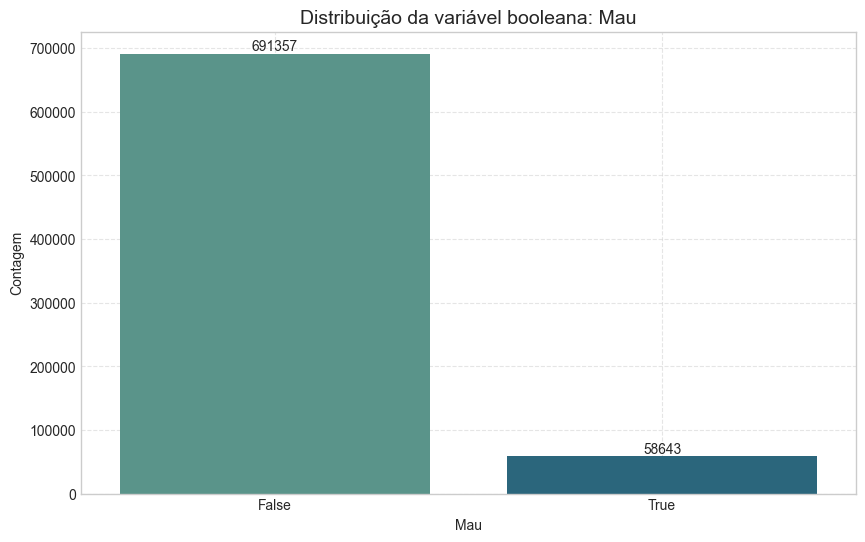

In [21]:
distribuicao(df, 'mau')

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Sexo:

     Adimplentes Inadimplentes
sexo                          
F         91.95%         8.05%
M         92.66%         7.34%


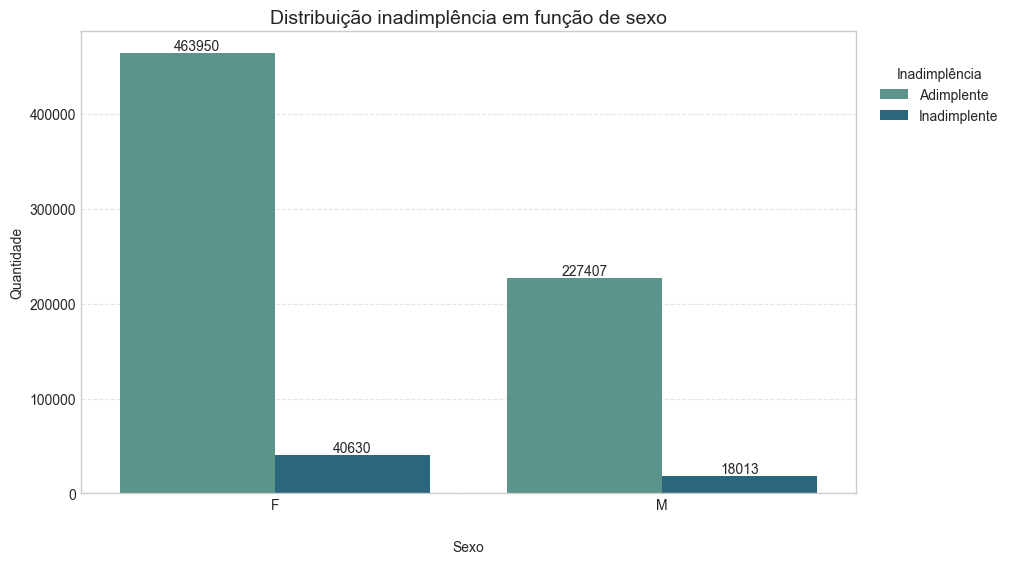

In [22]:
bivar(df, 'sexo')

Posse de Veículo:

                 Adimplentes Inadimplentes
posse_de_veiculo                          
False                 92.12%         7.88%
True                  92.27%         7.73%


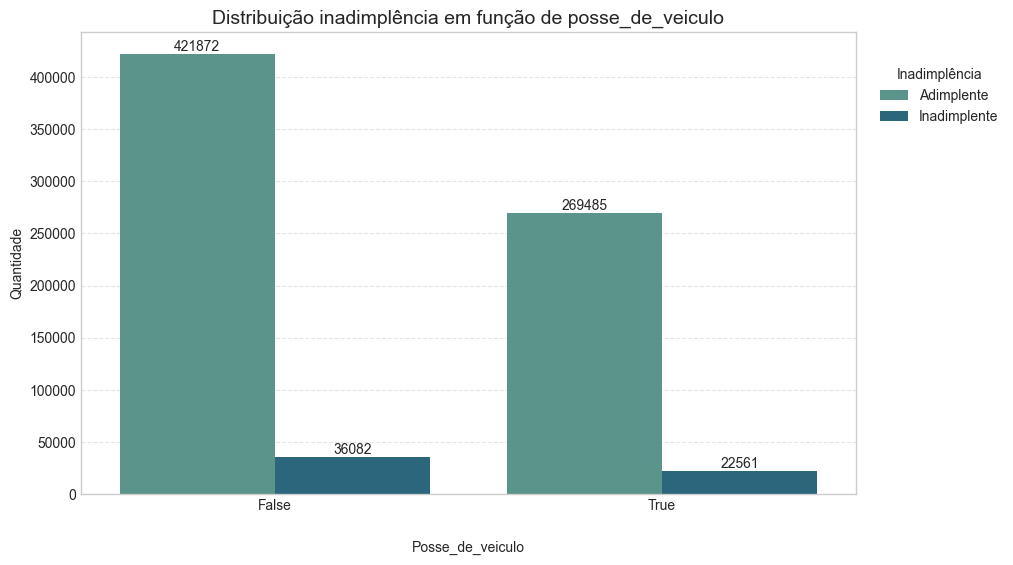

In [23]:
bivar(df, 'posse_de_veiculo')

Posse de imóvel:

                Adimplentes Inadimplentes
posse_de_imovel                          
False                91.15%         8.85%
True                 92.68%         7.32%


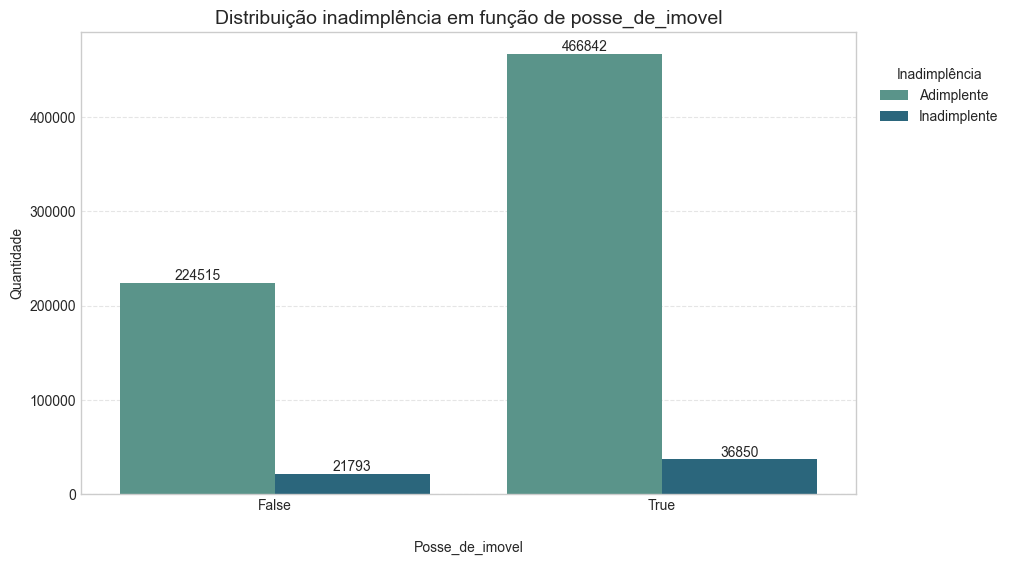

In [24]:
bivar(df, 'posse_de_imovel')

Quantidade de filhos:

            mau  media_qtd_filhos
0    Adimplente              0.43
1  Inadimplente              0.45


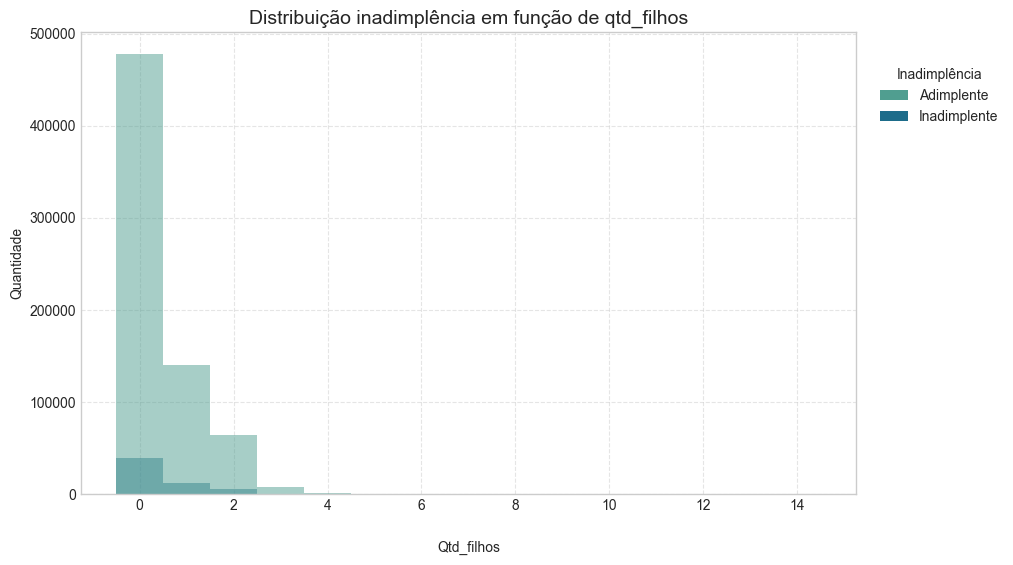

In [25]:
bivar(df, 'qtd_filhos')

Tipo de renda:

                 Adimplentes Inadimplentes
tipo_renda                                
Assalariado           91.91%         8.09%
Bolsista              95.84%         4.16%
Empresário            92.35%         7.65%
Pensionista           91.73%         8.27%
Servidor público      94.19%         5.81%


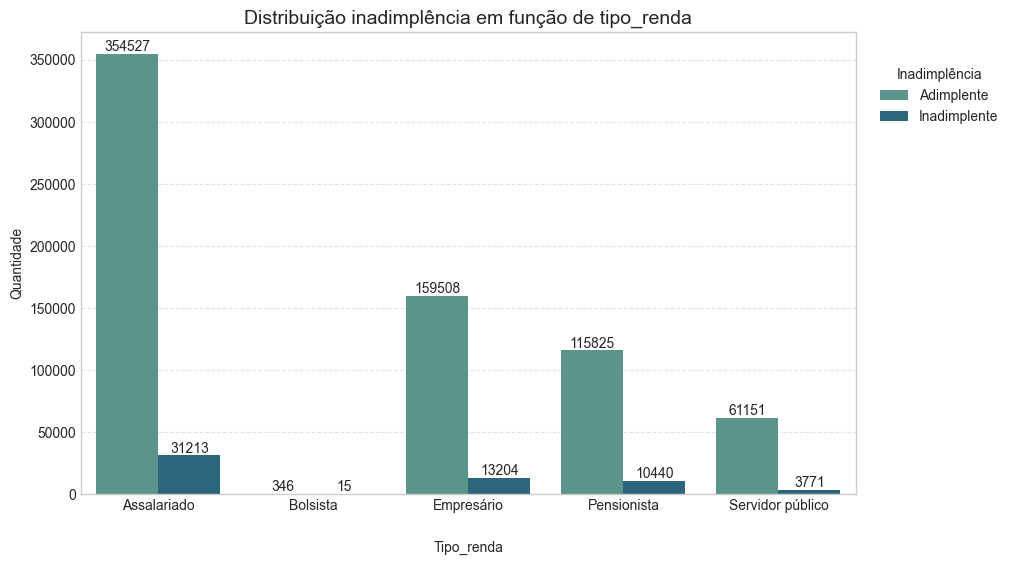

In [26]:
bivar(df, 'tipo_renda')

Educação:

             Adimplentes Inadimplentes
estado_civil                          
Casado            92.30%         7.70%
Separado          91.82%         8.18%
Solteiro          91.88%         8.12%
União             91.61%         8.39%
Viúvo             92.54%         7.46%


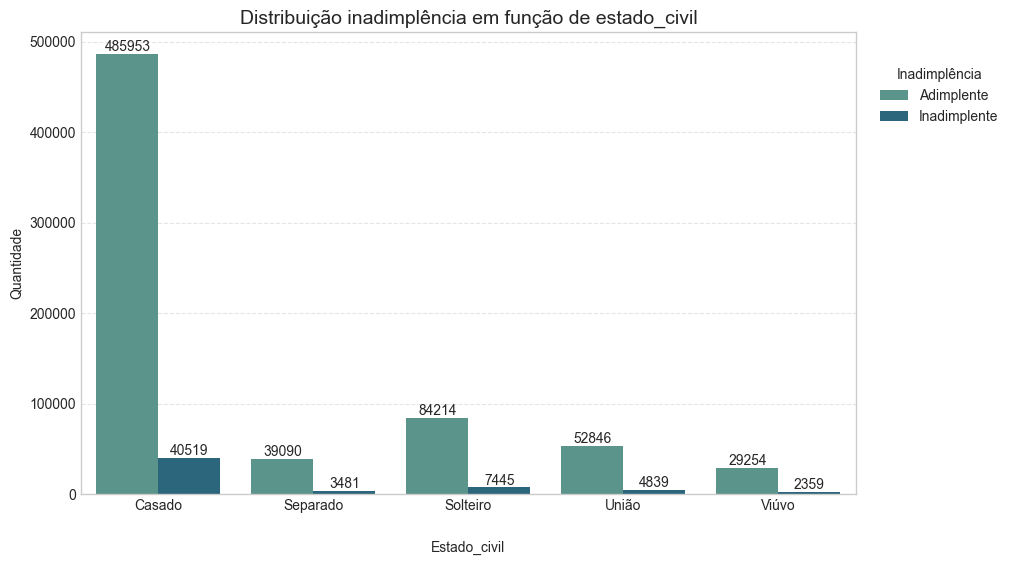

In [27]:
bivar(df, 'estado_civil')

Tipo de residência:

                Adimplentes Inadimplentes
tipo_residencia                          
Aluguel              90.98%         9.02%
Casa                 92.29%         7.71%
Com os pais          90.53%         9.47%
Comunitário          91.55%         8.45%
Estúdio              93.46%         6.54%
Governamental        91.78%         8.22%


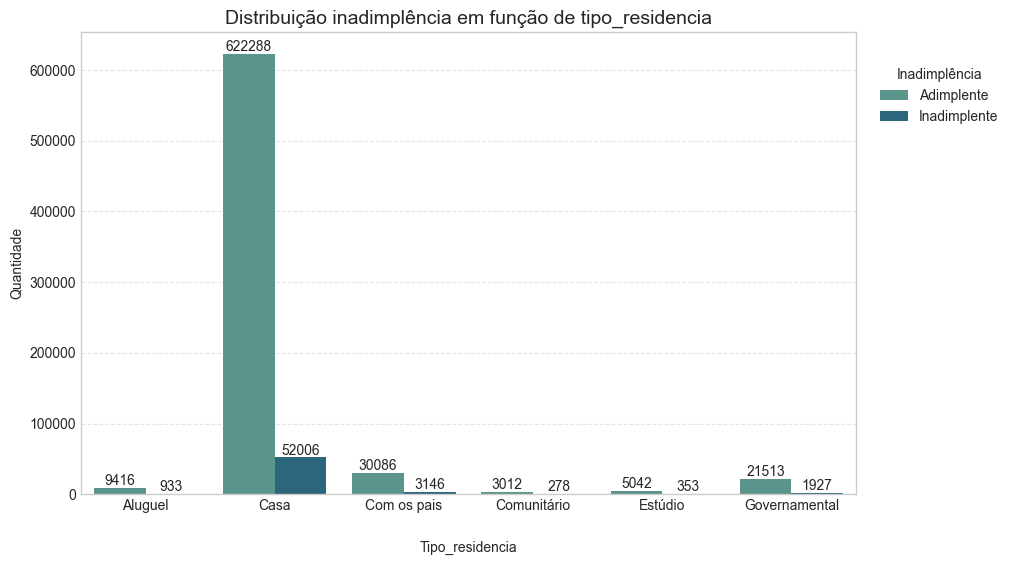

In [28]:
bivar(df, 'tipo_residencia')

Idade:

            mau  media_idade
0    Adimplente        43.90
1  Inadimplente        42.73


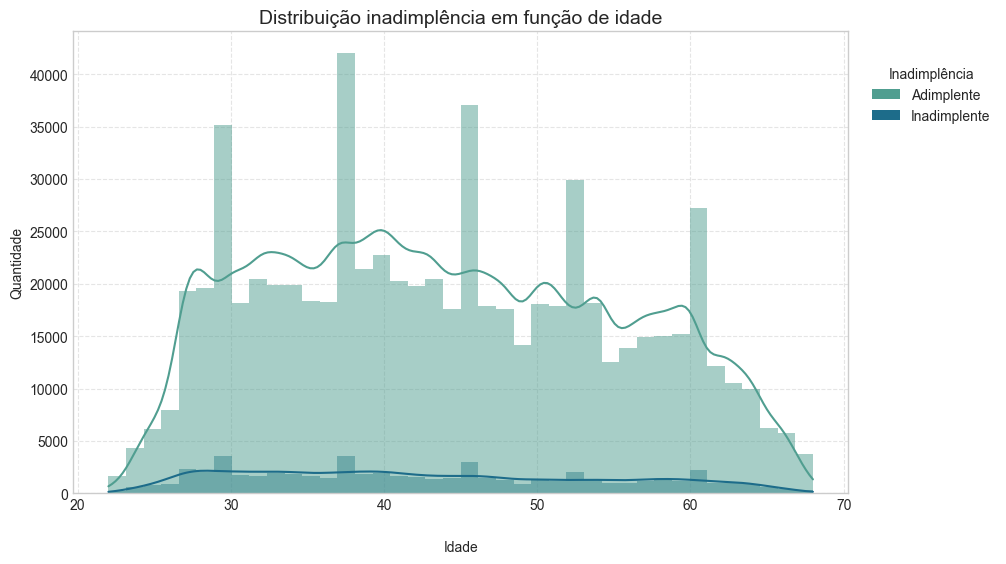

In [29]:
bivar(df, 'idade')

Tempo de emprego:

⚠️ A variável tempo_emprego contém 125957 valores nulos. Eles serão ignorados.

            mau  media_tempo_emprego
0    Adimplente                  8.0
1  Inadimplente                  4.7


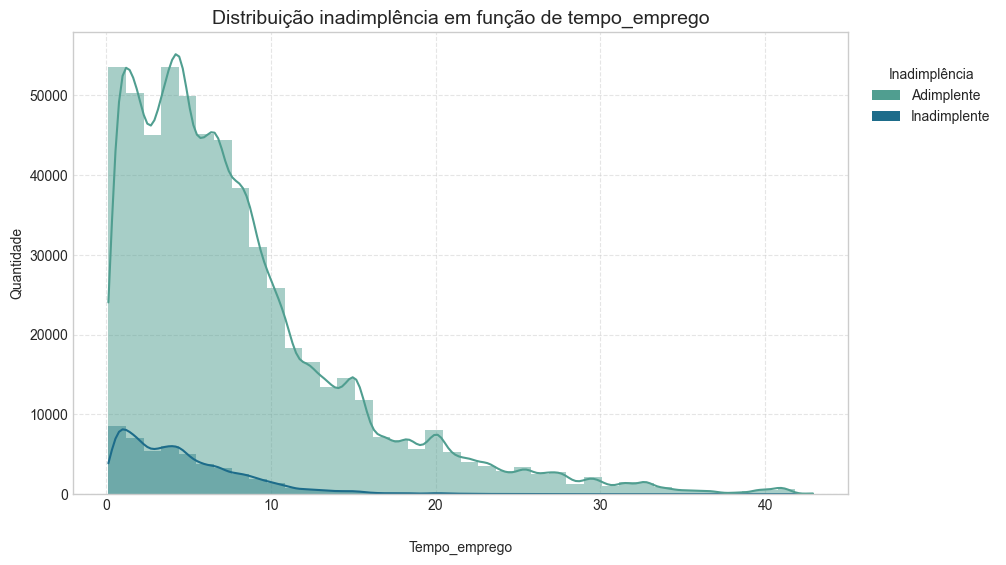

In [30]:
bivar(df, 'tempo_emprego')

Quantidade de pessoas na residência:

            mau  media_qt_pessoas_residencia
0    Adimplente                         2.21
1  Inadimplente                         2.22


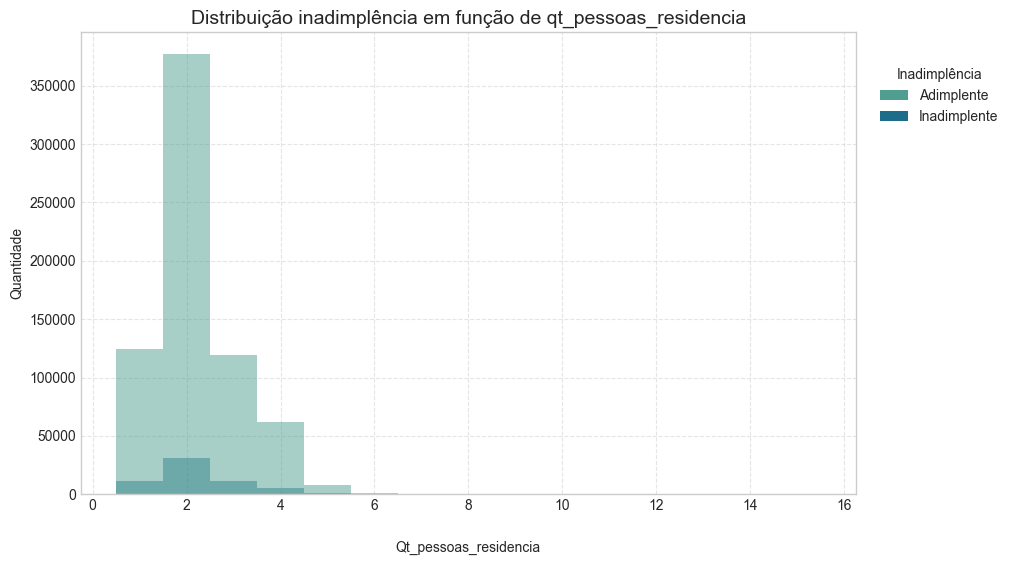

In [31]:
bivar(df, 'qt_pessoas_residencia')

Renda:

            mau  media_renda
0    Adimplente     24804.69
1  Inadimplente      4774.87


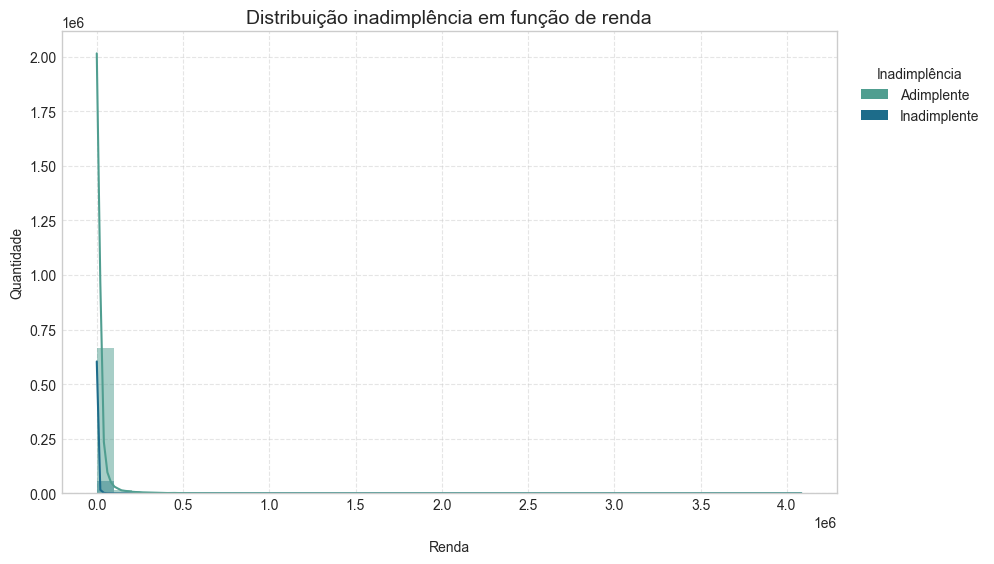

In [32]:
bivar(df, 'renda')

Log da renda:

            mau  media_log_renda
0    Adimplente             9.13
1  Inadimplente             7.89


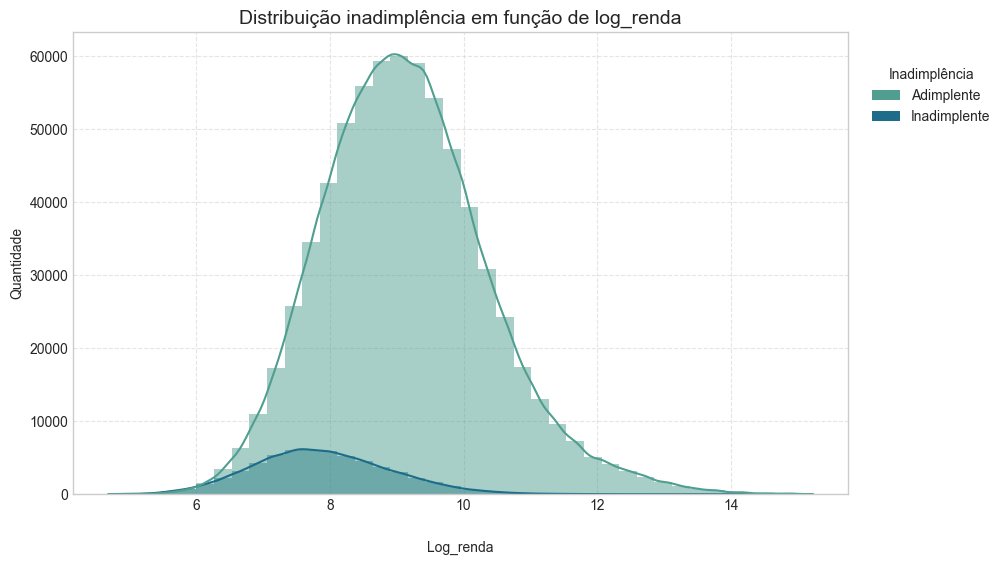

In [33]:
bivar(df, 'log_renda')

        Adimplentes Inadimplentes
mes                              
2015-01      87.89%        12.11%
2015-02      90.13%         9.87%
2015-03      92.64%         7.36%
2015-04      94.67%         5.33%
2015-05      96.30%         3.70%
2015-06      96.97%         3.03%
2015-07      97.28%         2.72%
2015-08      97.05%         2.95%
2015-09      96.20%         3.80%
2015-10      94.79%         5.21%
2015-11      92.51%         7.49%
2015-12      90.29%         9.71%
2016-01      87.59%        12.41%
2016-02      85.23%        14.77%
2016-03      83.18%        16.82%


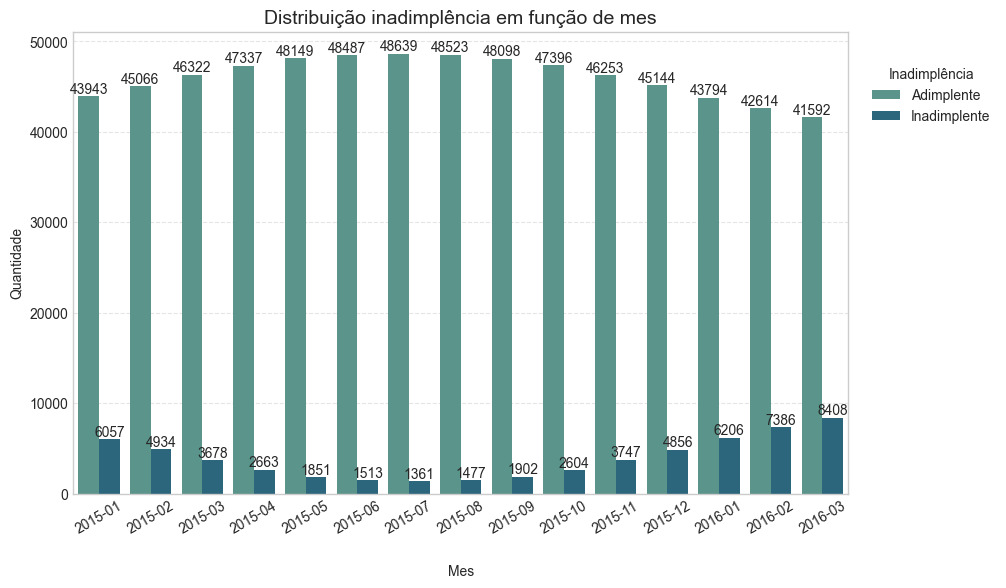

In [34]:
bivar(df, 'mes')

Vemos que a distribuição de inadimplência ao longo do tempo é um pouco assimétrica, sendo mais alta nos meses iniciais do ano e mais baixa na metade dele. 

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratamento missing values

In [35]:
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
mes                           0
log_renda                     0
dtype: int64

De todas as variáveis no DataFrame, `tempo_emprego` é a única com missing values.

In [36]:
perc_missing = round((df.tempo_emprego.isnull().sum() / len(df.tempo_emprego))*100, 2)
print(f'Total de linhas: {len(df.tempo_emprego)}')
print(f'Total de linhas faltantes: {df.tempo_emprego.isnull().sum()}')
print(f'Porcentagem valores missing da variável: {perc_missing}%')

Total de linhas: 750000
Total de linhas faltantes: 125957
Porcentagem valores missing da variável: 16.79%


Para evitar de criar um viés no modelo, como acontece nos casos de exclusão ou substituição pela média, o tratamento da variável será feita através dos dados de um modelo criado para prever tempo de emprego com base nas outras variáveis do DataFrame.

In [37]:
df_rfr = df.drop(columns=['data_ref', 'index', 'mes', 'log_renda'])
df_rfr[['posse_de_veiculo', 'posse_de_imovel', 'mau']] = df_rfr[['posse_de_veiculo', 'posse_de_imovel', 'mau']].astype(int)
df_rfr['sexo'] = df_rfr['sexo'].map({'F': 1, 'M': 0})

df_completo = df_rfr[df_rfr['tempo_emprego'].notnull()]
df_faltante = df_rfr[df_rfr['tempo_emprego'].isnull()]

X_treino = df_completo.drop(columns=['tempo_emprego'])
y_treino = df_completo['tempo_emprego']

X_teste = df_faltante.drop(columns=['tempo_emprego'])

X_treino_dummies = pd.get_dummies(X_treino, drop_first=True)
X_teste_dummies = pd.get_dummies(X_teste, drop_first=True)

X_teste_dummies = X_teste_dummies.reindex(columns=X_treino_dummies.columns, fill_value=0)

modelo_base = RandomForestRegressor(n_estimators=70, random_state=23, n_jobs=-1)
seletor = SelectFromModel(estimator= modelo_base, threshold='median')
seletor.fit(X_treino_dummies, y_treino)

X_treino_selecionado = seletor.transform(X_treino_dummies)
X_teste_selecionado = seletor.transform(X_teste_dummies)

modelo_final = RandomForestRegressor(n_estimators=70, random_state=23, n_jobs=-1)
modelo_final.fit(X_treino_selecionado, y_treino)

valores_imputados = modelo_final.predict(X_teste_selecionado)

Substituindo o valores missing pelos valores previstos pelo modelo:

In [38]:
df.loc[df['tempo_emprego'].isnull(), 'tempo_emprego'] = valores_imputados

Não há mais nenhum missing value:

In [39]:
df.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
mes                      0
log_renda                0
dtype: int64

            mau  media_tempo_emprego
0    Adimplente                 7.96
1  Inadimplente                 4.82


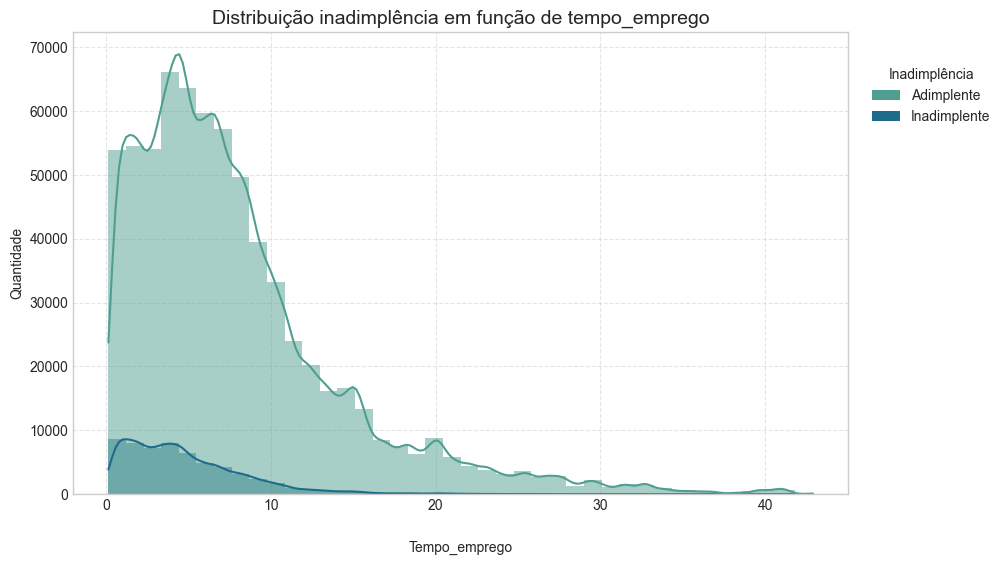

In [40]:
bivar(df, 'tempo_emprego')

A utilização do modelo para tratamento dos missing values não alterou significativamente a média de tempo de emprego para Adimplente e Inadimplente. Mantendo a distribuição semelhante a anterior, sem criar um viés.

### Outliers:

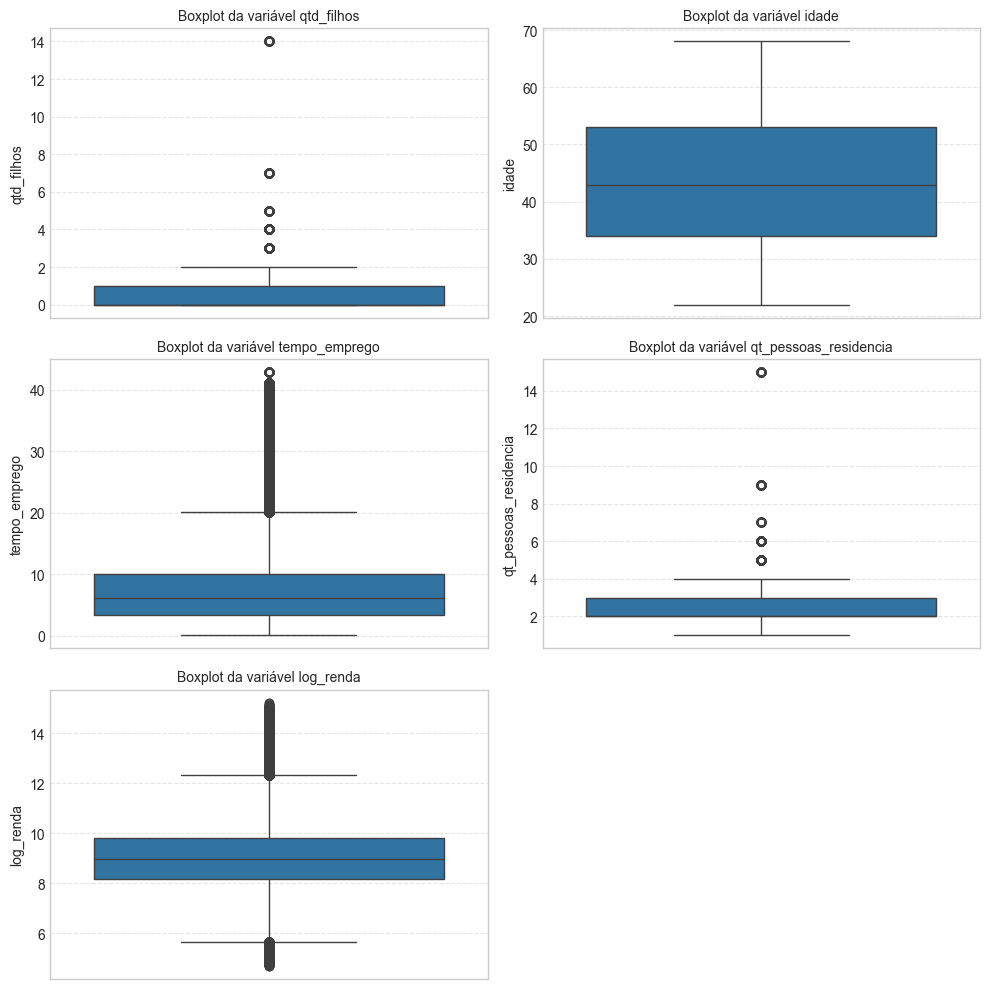

In [41]:
box_outlier(df)

As variáveis `qtd_filhos`, `qt_pessoas_residencia` e `log_renda` apresentam alguns outliers e serão tratadas com a função cap_outliers_iqr, utilizando a regra do intervalo interquatilico.

A variável `tempo_emprego` não será incluida pois a mesma apresenta distribuição levemente assimétrica, caso aplicada a mesma regra muitos dados serão perdidos.

In [42]:
variaveis_para_capping = ['qtd_filhos', 'qt_pessoas_residencia', 'log_renda']

df2 = df.copy()

for var in variaveis_para_capping:
    cap_outliers_iqr(df2, var)

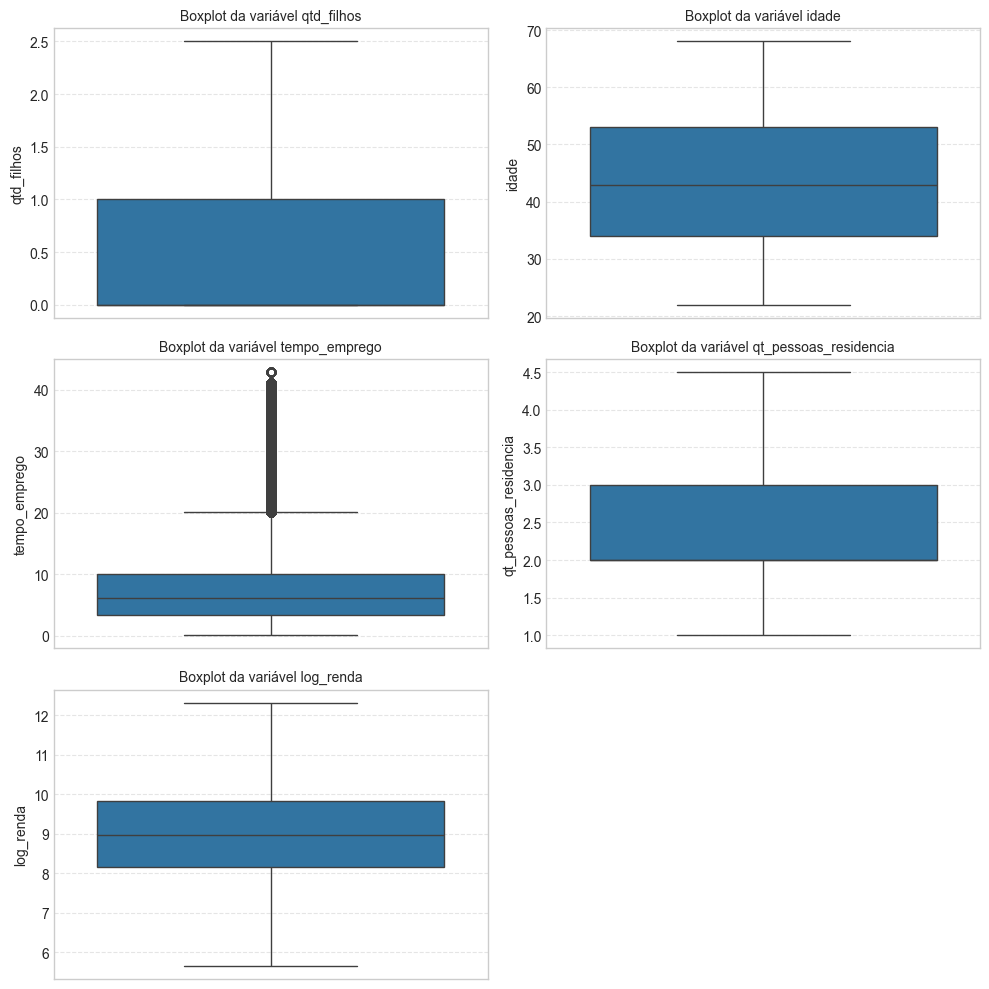

In [43]:
box_outlier(df2)

### Agrupamentos e zeros estruturais:

qt_bom  qt_mau       mau sexo    cont        ep   mau_sup   mau_inf  \
sexo                                                                        
F     463950   40630  0.080522    F  504580  0.000383  0.081273  0.079772   
M     227407   18013  0.073397    M  245420  0.000526  0.074428  0.072365   

         logit  logit_sup  logit_inf       woe   woe_sup   woe_inf  
sexo                                                                
F    -2.435270  -2.425173  -2.445454  0.031918  0.042016  0.021734  
M    -2.535648  -2.520574  -2.550918 -0.068460 -0.053386 -0.083730

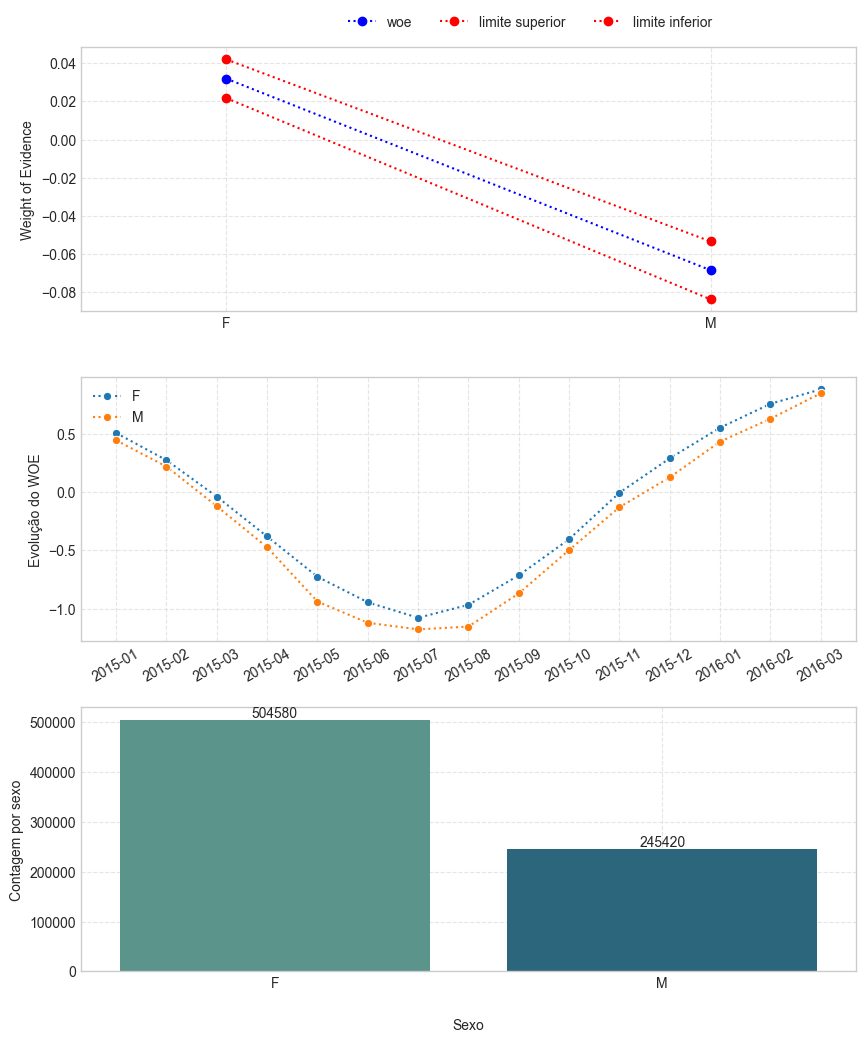

In [44]:
woe_discreta(df2, 'sexo')

qt_bom  qt_mau       mau  posse_de_veiculo    cont  \
posse_de_veiculo                                                       
False             421872   36082  0.078790             False  457954   
True              269485   22561  0.077252              True  292046   

                        ep  mau_sup   mau_inf     logit  logit_sup  logit_inf  \
posse_de_veiculo                                                                
False             0.000398  0.07957  0.078009 -2.458908  -2.448206  -2.469707   
True              0.000494  0.07822  0.076283 -2.480290  -2.466783  -2.493953   

                       woe   woe_sup   woe_inf  
posse_de_veiculo                                
False             0.008280  0.018982 -0.002519  
True             -0.013102  0.000405 -0.026765

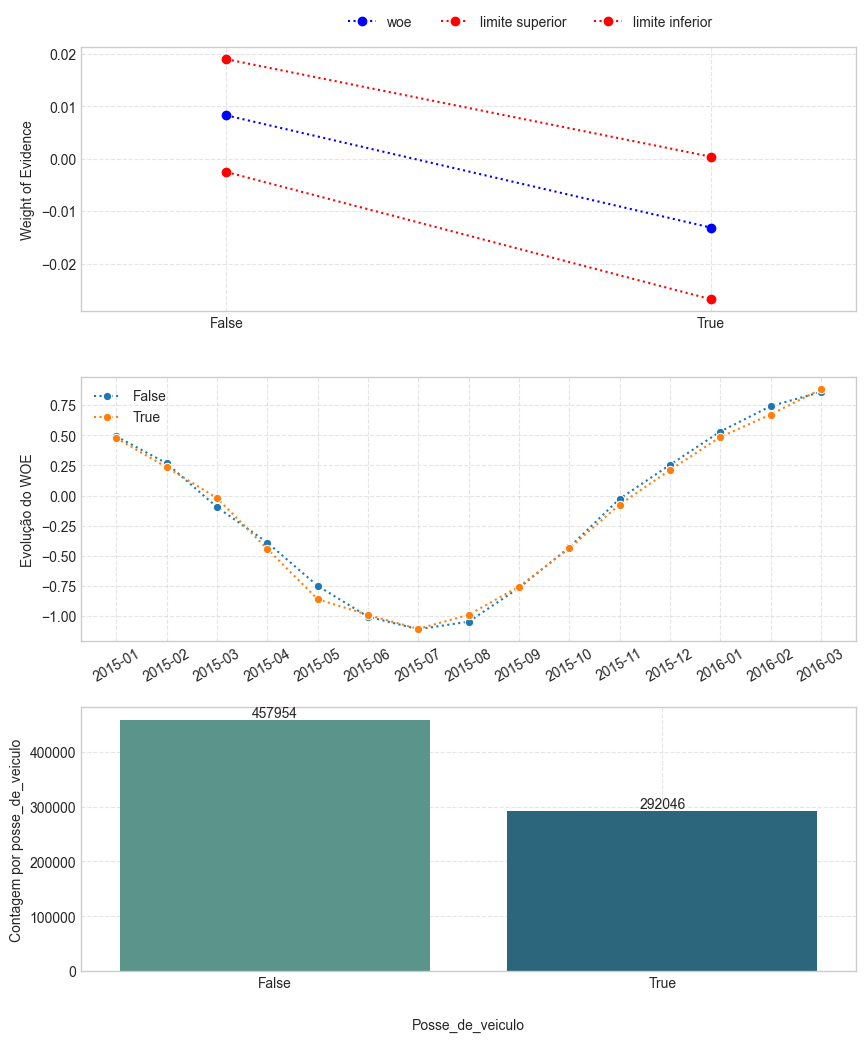

In [45]:
woe_discreta(df2, 'posse_de_veiculo')

qt_bom  qt_mau       mau             educacao    cont  \
educacao                                                                     
Fundamental            7789     786  0.091662          Fundamental    8575   
Superior incompleto   27025    2446  0.082997  Superior incompleto   29471   
Médio                466106   40730  0.080361                Médio  506836   
Pós graduação           753      59  0.072660        Pós graduação     812   
Superior completo    189684   14622  0.071569    Superior completo  204306   

                           ep   mau_sup   mau_inf     logit  logit_sup  \
educacao                                                                 
Fundamental          0.003116  0.097770  0.085554 -2.293511  -2.222252   
Superior incompleto  0.001607  0.086147  0.079847 -2.402308  -2.361619   
Médio                0.000382  0.081110  0.079613 -2.437448  -2.427364   
Pós graduação        0.009109  0.090541  0.054779 -2.546528  -2.307049   
Superior completo    0.000570  0.072687  0.070451 -2.562832  -2.546130   

                     logit_inf       woe   woe_sup   woe_inf  
educacao                                                      
Fundamental          -2.369175  0.173677  0.244936  0.098013  
Superior incompleto  -2.444427  0.064880  0.105569  0.022761  
Médio                -2.447619  0.029740  0.039824  0.019570  
Pós graduação        -2.848105 -0.079340  0.160139 -0.380917  
Superior completo    -2.579777 -0.095644 -0.078942 -0.112588

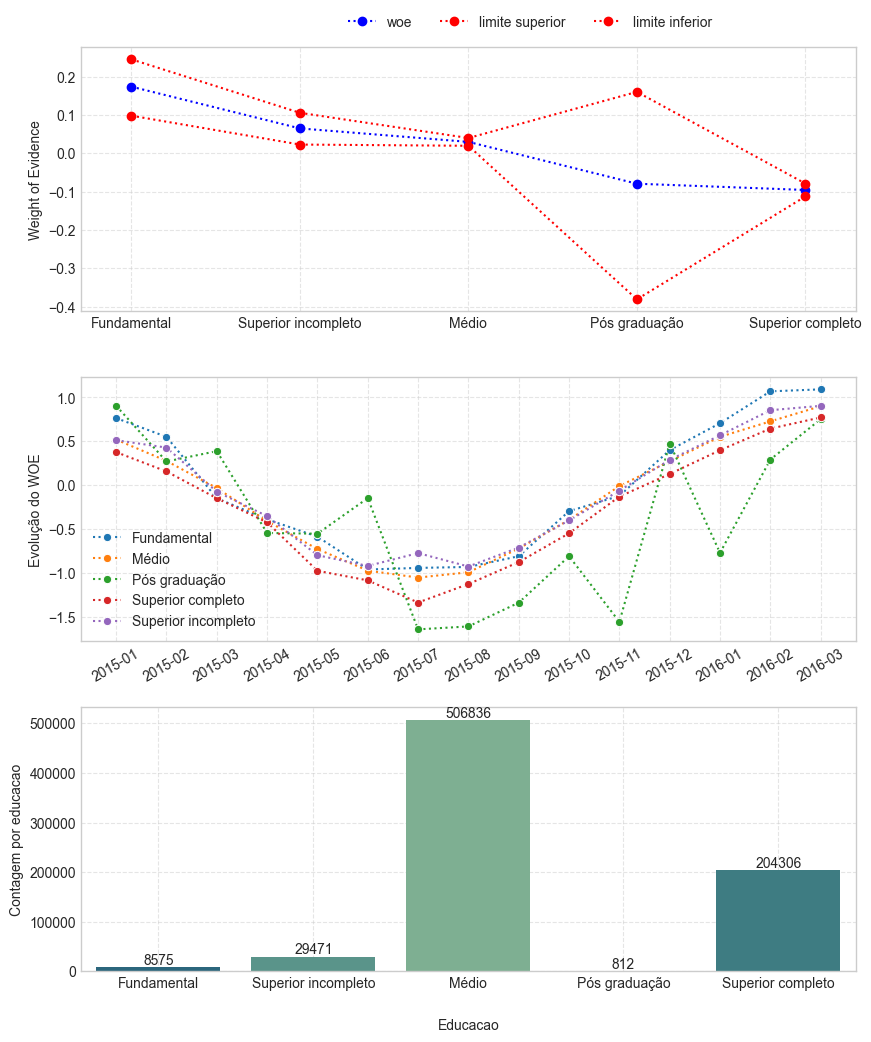

In [46]:
woe_discreta(df2, 'educacao')

qt_bom  qt_mau       mau  \
educacao                                                    
Fundamental/Medio/SupIncompleto  500920   43962  0.080682   
Superior/Pos                     190437   14681  0.071573   

                                                        educacao    cont  \
educacao                                                                   
Fundamental/Medio/SupIncompleto  Fundamental/Medio/SupIncompleto  544882   
Superior/Pos                                        Superior/Pos  205118   

                                       ep   mau_sup   mau_inf     logit  \
educacao                                                                  
Fundamental/Medio/SupIncompleto  0.000369  0.081405  0.079959 -2.433121   
Superior/Pos                     0.000569  0.072689  0.070458 -2.562767   

                                 logit_sup  logit_inf       woe   woe_sup  \
educacao                                                                    
Fundamental/Medio/SupIncompleto  -2.423411  -2.442910  0.034067  0.043777   
Superior/Pos                     -2.546099  -2.579677 -0.095579 -0.078911   

                                  woe_inf  
educacao                                   
Fundamental/Medio/SupIncompleto  0.024278  
Superior/Pos                    -0.112489

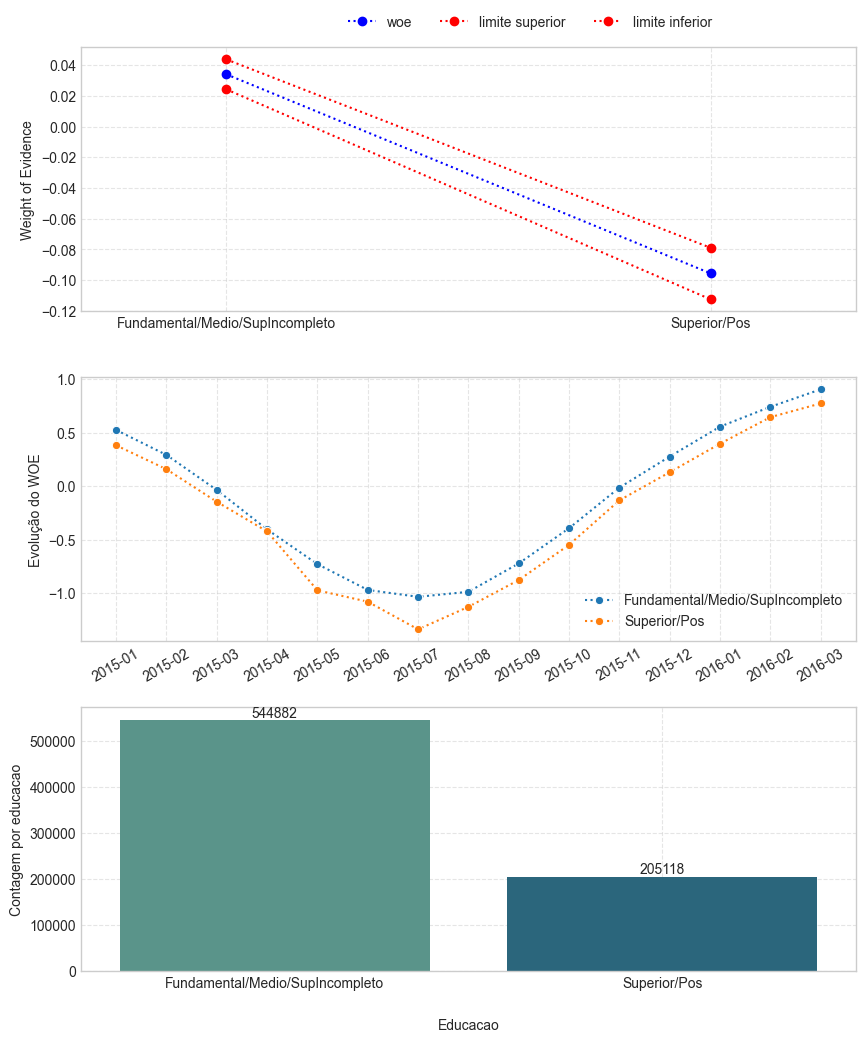

In [47]:
df2.replace(
    {
        'educacao':
        {
            'Pós graduação':'Superior/Pos', 
            'Superior completo': 'Superior/Pos',
            'Superior incompleto': 'Fundamental/Medio/SupIncompleto',
            'Fundamental':'Fundamental/Medio/SupIncompleto',
            'Médio': 'Fundamental/Medio/SupIncompleto'
        }
    }, inplace=True)

woe_discreta(df2, 'educacao')

qt_bom  qt_mau       mau tipo_residencia    cont        ep  \
tipo_residencia                                                               
Com os pais       30086    3146  0.094668     Com os pais   33232  0.001606   
Aluguel            9416     933  0.090154         Aluguel   10349  0.002815   
Comunitário        3012     278  0.084498     Comunitário    3290  0.004849   
Governamental     21513    1927  0.082210   Governamental   23440  0.001794   
Casa             622288   52006  0.077127            Casa  674294  0.000325   
Estúdio            5042     353  0.065431         Estúdio    5395  0.003367   

                  mau_sup   mau_inf     logit  logit_sup  logit_inf       woe  \
tipo_residencia                                                                 
Com os pais      0.097815  0.091520 -2.257928  -2.221736  -2.295214  0.209260   
Aluguel          0.095672  0.084635 -2.311760  -2.246264  -2.380974  0.155428   
Comunitário      0.094006  0.074991 -2.382738  -2.265675  -2.512435  0.084450   
Governamental    0.085727  0.078693 -2.412693  -2.366968  -2.460235  0.054495   
Casa             0.077763  0.076490 -2.482044  -2.473131  -2.491024 -0.014856   
Estúdio          0.072031  0.058831 -2.659090  -2.555902  -2.772455 -0.191902   

                  woe_sup   woe_inf  
tipo_residencia                      
Com os pais      0.245452  0.171974  
Aluguel          0.220924  0.086214  
Comunitário      0.201513 -0.045247  
Governamental    0.100221  0.006953  
Casa            -0.005943 -0.023836  
Estúdio         -0.088714 -0.305267

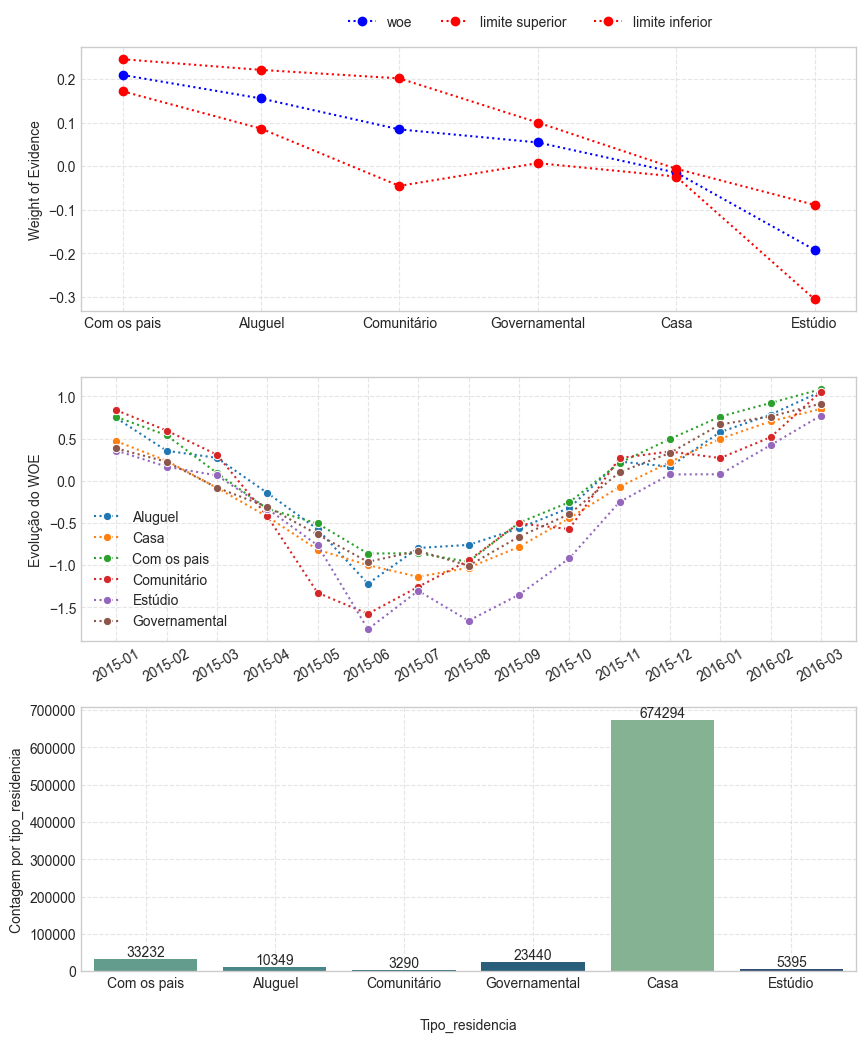

In [48]:
woe_discreta(df2, 'tipo_residencia')

qt_bom  qt_mau       mau  \
tipo_residencia                                       
Pais/Aluguel                39502    4079  0.093596   
Comunitario/Governamental   24525    2205  0.082492   
Casa/Estudio               627330   52359  0.077034   

                                     tipo_residencia    cont        ep  \
tipo_residencia                                                          
Pais/Aluguel                            Pais/Aluguel   43581  0.001395   
Comunitario/Governamental  Comunitario/Governamental   26730  0.001683   
Casa/Estudio                            Casa/Estudio  679689  0.000323   

                            mau_sup   mau_inf     logit  logit_sup  logit_inf  \
tipo_residencia                                                                 
Pais/Aluguel               0.096330  0.090861 -2.270499  -2.238679  -2.303165   
Comunitario/Governamental  0.085790  0.079193 -2.408965  -2.366161  -2.453357   
Casa/Estudio               0.077668  0.076400 -2.483349  -2.474467  -2.492298   

                                woe   woe_sup   woe_inf  
tipo_residencia                                          
Pais/Aluguel               0.196689  0.228509  0.164023  
Comunitario/Governamental  0.058223  0.101028  0.013831  
Casa/Estudio              -0.016161 -0.007278 -0.025110

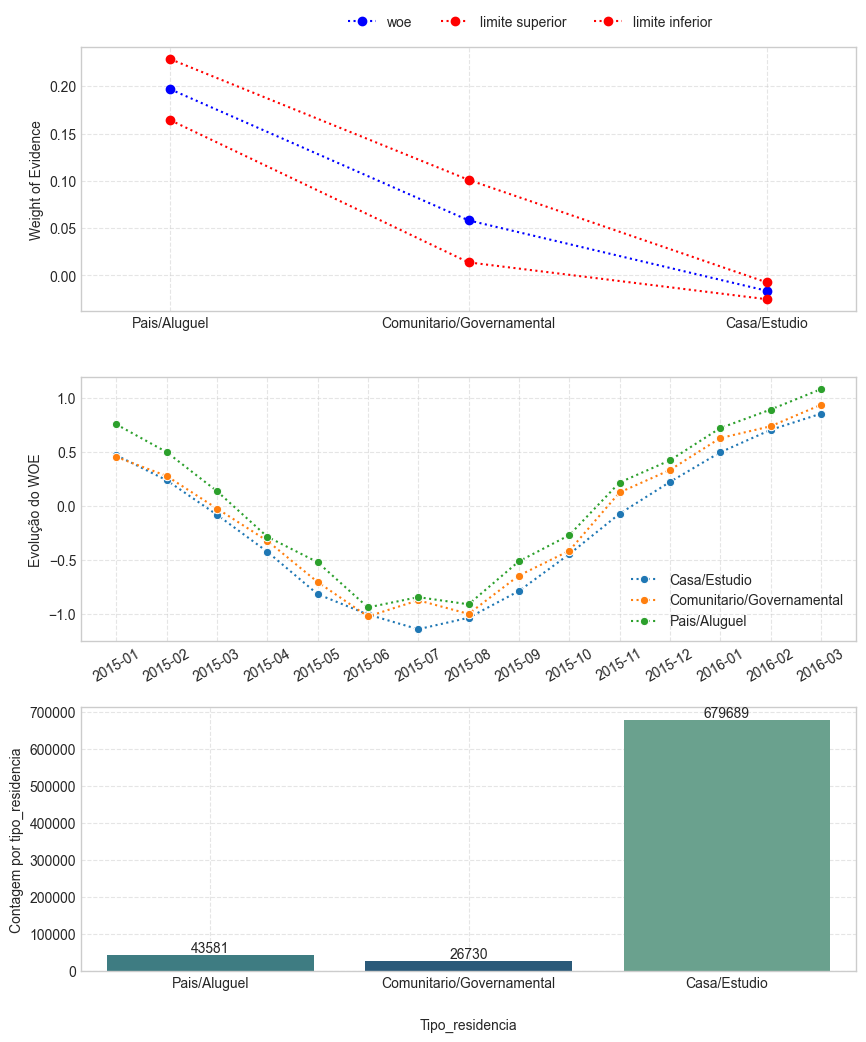

In [49]:
df2.replace(
    {
        'tipo_residencia':
        {
            'Comunitário':'Comunitario/Governamental', 
            'Governamental': 'Comunitario/Governamental',
            'Com os pais': 'Pais/Aluguel',
            'Aluguel': 'Pais/Aluguel',
            'Casa': 'Casa/Estudio',
            'Estúdio':'Casa/Estudio'
        }
    }, inplace=True)

woe_discreta(df2, 'tipo_residencia')

qt_bom  qt_mau       mau estado_civil    cont        ep  \
estado_civil                                                            
União          52846    4839  0.083887        União   57685  0.001154   
Separado       39090    3481  0.081769     Separado   42571  0.001328   
Solteiro       84214    7445  0.081225     Solteiro   91659  0.000902   
Casado        485953   40519  0.076963       Casado  526472  0.000367   
Viúvo          29254    2359  0.074621        Viúvo   31613  0.001478   

               mau_sup   mau_inf     logit  logit_sup  logit_inf       woe  \
estado_civil                                                                 
União         0.086149  0.081624 -2.390674  -2.361590  -2.420479  0.076514   
Separado      0.084372  0.079166 -2.418547  -2.384371  -2.453729  0.048641   
Solteiro      0.082994  0.079456 -2.425819  -2.402352  -2.449755  0.041370   
Casado        0.077683  0.076243 -2.484341  -2.474249  -2.494519 -0.017153   
Viúvo         0.077518  0.071724 -2.517779  -2.476557  -2.560498 -0.050590   

               woe_sup   woe_inf  
estado_civil                      
União         0.105598  0.046709  
Separado      0.082817  0.013459  
Solteiro      0.064836  0.017433  
Casado       -0.007061 -0.027331  
Viúvo        -0.009369 -0.093310

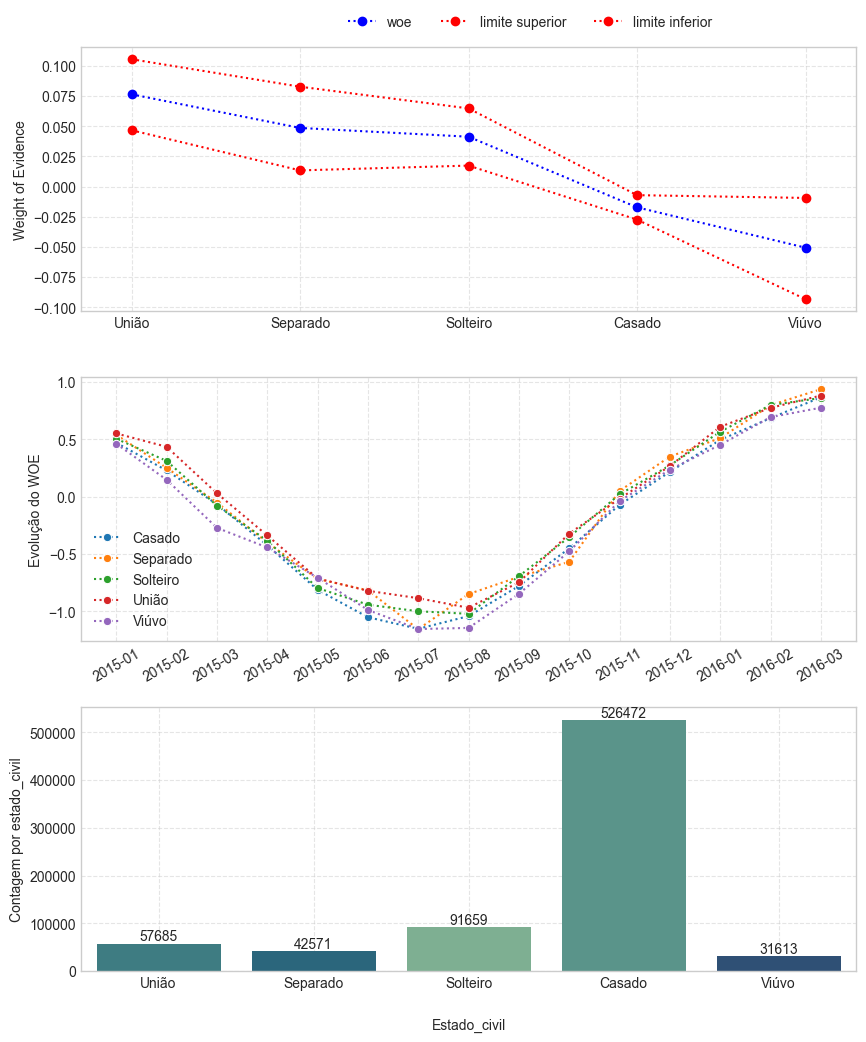

In [50]:
woe_discreta(df2, 'estado_civil')

c:\Users\nobre\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


qt_bom  qt_mau       mau        tipo_renda    cont  \
tipo_renda                                                             
Pensionista       115825   10440  0.082683       Pensionista  126265   
Assalariado       354527   31213  0.080917       Assalariado  385740   
Empresário        159508   13204  0.076451        Empresário  172712   
Servidor público   61151    3771  0.058085  Servidor público   64922   
Bolsista             346      15  0.041551          Bolsista     361   

                        ep   mau_sup   mau_inf     logit  logit_sup  \
tipo_renda                                                            
Pensionista       0.000775  0.084202  0.081164 -2.406436  -2.386573   
Assalariado       0.000439  0.081778  0.080057 -2.429950  -2.418434   
Empresário        0.000639  0.077704  0.075198 -2.491574  -2.473957   
Servidor público  0.000918  0.059884  0.056286 -2.786006  -2.753587   
Bolsista          0.010503  0.062207  0.020896 -3.138389  -2.713068   

                  logit_inf       woe   woe_sup   woe_inf  
tipo_renda                                                 
Pensionista       -2.426634  0.060752  0.080615  0.040555  
Assalariado       -2.441578  0.037238  0.048754  0.025610  
Empresário        -2.509458 -0.024386 -0.006769 -0.042270  
Servidor público  -2.819381 -0.318818 -0.286399 -0.352193  
Bolsista          -3.847087 -0.671200 -0.245880 -1.379899

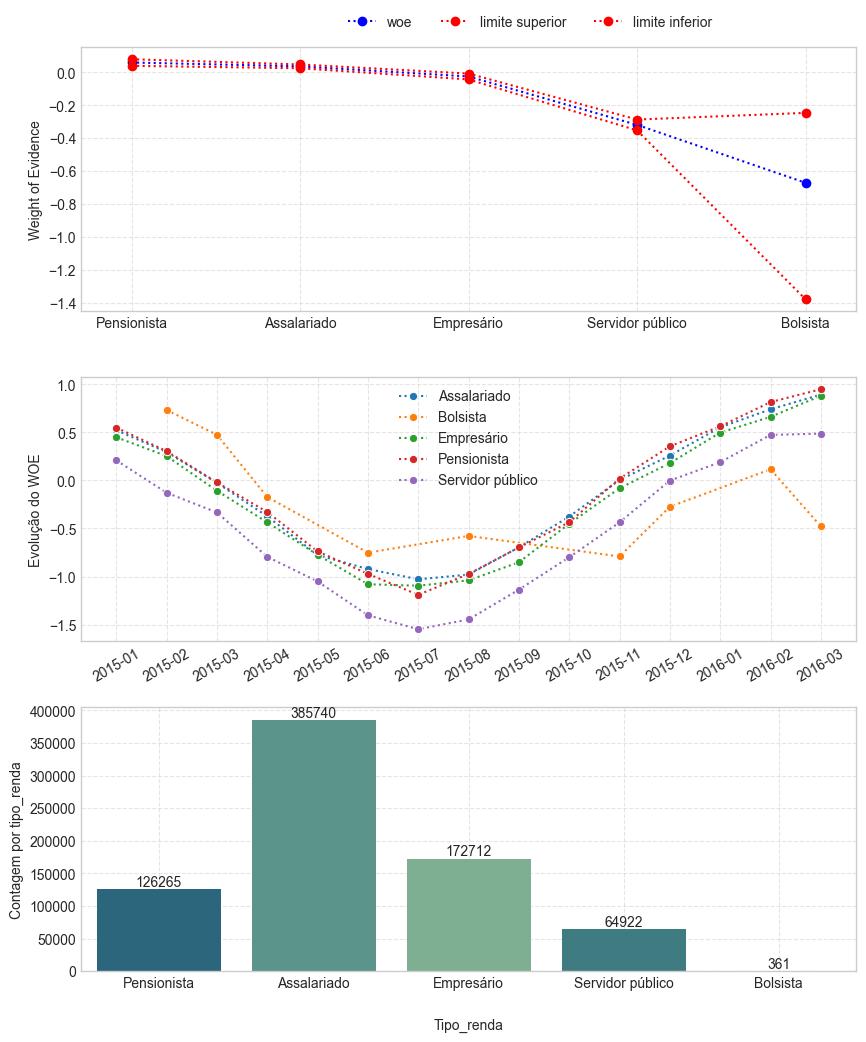

In [51]:
woe_discreta(df2, 'tipo_renda')

qt_bom  qt_mau       mau  \
tipo_renda                                            
Pensionista                115825   10440  0.082683   
Assalariado                354527   31213  0.080917   
Empresário                 159508   13204  0.076451   
Servidor público/Bolsista   61497    3786  0.057994   

                                          tipo_renda    cont        ep  \
tipo_renda                                                               
Pensionista                              Pensionista  126265  0.000775   
Assalariado                              Assalariado  385740  0.000439   
Empresário                                Empresário  172712  0.000639   
Servidor público/Bolsista  Servidor público/Bolsista   65283  0.000915   

                            mau_sup   mau_inf     logit  logit_sup  logit_inf  \
tipo_renda                                                                      
Pensionista                0.084202  0.081164 -2.406436  -2.386573  -2.426634   
Assalariado                0.081778  0.080057 -2.429950  -2.418434  -2.441578   
Empresário                 0.077704  0.075198 -2.491574  -2.473957  -2.509458   
Servidor público/Bolsista  0.059787  0.056201 -2.787678  -2.755325  -2.820985   

                                woe   woe_sup   woe_inf  
tipo_renda                                               
Pensionista                0.060752  0.080615  0.040555  
Assalariado                0.037238  0.048754  0.025610  
Empresário                -0.024386 -0.006769 -0.042270  
Servidor público/Bolsista -0.320490 -0.288137 -0.353796

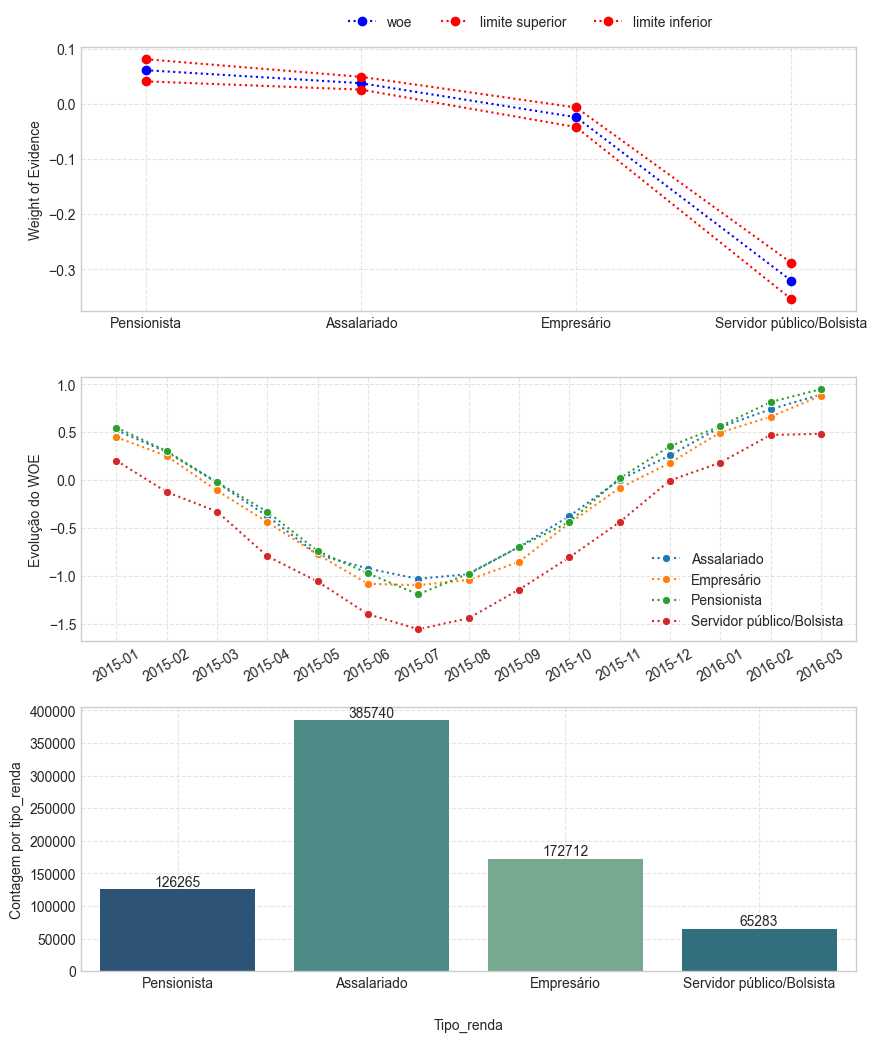

In [52]:
df2.replace(
    {
    'tipo_renda':
        {
            'Servidor público': 'Servidor público/Bolsista',
            'Bolsista': 'Servidor público/Bolsista'
        }
    }, inplace=True)

woe_discreta(df2, 'tipo_renda')

qt_bom  qt_mau       mau  qtd_filhos    cont        ep   mau_sup  \
qtd_filhos                                                                     
0.0         477683   39648  0.076640         0.0  517331  0.000370  0.077364   
1.0         140345   12676  0.082838         1.0  153021  0.000705  0.084219   
2.0          64142    5490  0.078843         2.0   69632  0.001021  0.080845   
2.5           9187     829  0.082768         2.5   10016  0.002753  0.088164   

             mau_inf     logit  logit_sup  logit_inf       woe   woe_sup  \
qtd_filhos                                                                 
0.0         0.075915 -2.488907  -2.478707  -2.499195 -0.021719 -0.011519   
1.0         0.081457 -2.404393  -2.386352  -2.422710  0.062795  0.080836   
2.0         0.076841 -2.458171  -2.430924  -2.486058  0.009017  0.036264   
2.5         0.077371 -2.405325  -2.336259  -2.478616  0.061864  0.130929   

             woe_inf  
qtd_filhos            
0.0        -0.032007  
1.0         0.044478  
2.0        -0.018870  
2.5        -0.011428

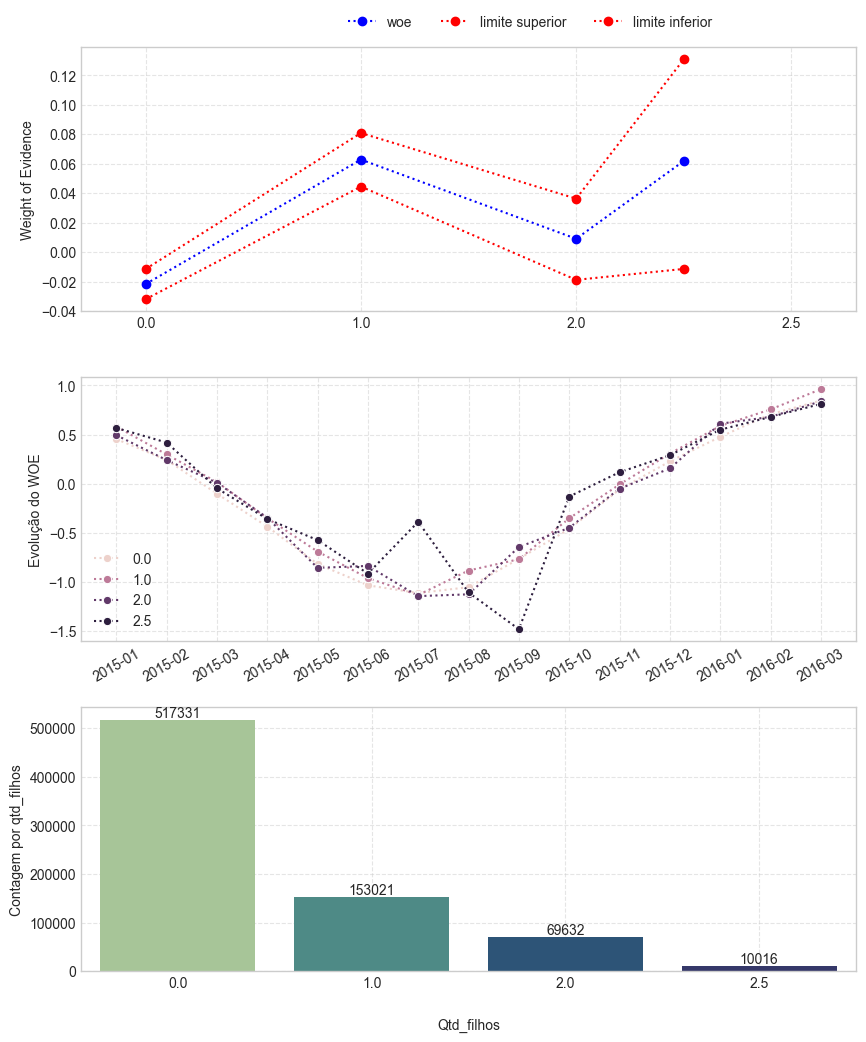

In [53]:
woe_discreta(df2, 'qtd_filhos')

qt_bom  qt_mau       mau  qt_pessoas_residencia  \
qt_pessoas_residencia                                                    
1.0                    124842   10926  0.080476                    1.0   
2.0                    377007   30769  0.075456                    2.0   
3.0                    119168   10900  0.083802                    3.0   
4.0                     61511    5248  0.078611                    4.0   
4.5                      8829     800  0.083082                    4.5   

                         cont        ep   mau_sup   mau_inf     logit  \
qt_pessoas_residencia                                                   
1.0                    135768  0.000738  0.081923  0.079029 -2.435904   
2.0                    407776  0.000414  0.076266  0.074645 -2.505756   
3.0                    130068  0.000768  0.085308  0.082296 -2.391771   
4.0                     66759  0.001042  0.080653  0.076570 -2.461369   
4.5                      9629  0.002813  0.088596  0.077569 -2.401185   

                       logit_sup  logit_inf       woe   woe_sup   woe_inf  
qt_pessoas_residencia                                                      
1.0                    -2.416508  -2.455620  0.031284  0.050680  0.011568  
2.0                    -2.494192  -2.517434 -0.038568 -0.027004 -0.050246  
3.0                    -2.372317  -2.411547  0.075417  0.094871  0.055642  
4.0                    -2.433512  -2.489896  0.005819  0.033676 -0.022708  
4.5                    -2.330901  -2.475847  0.066003  0.136287 -0.008659

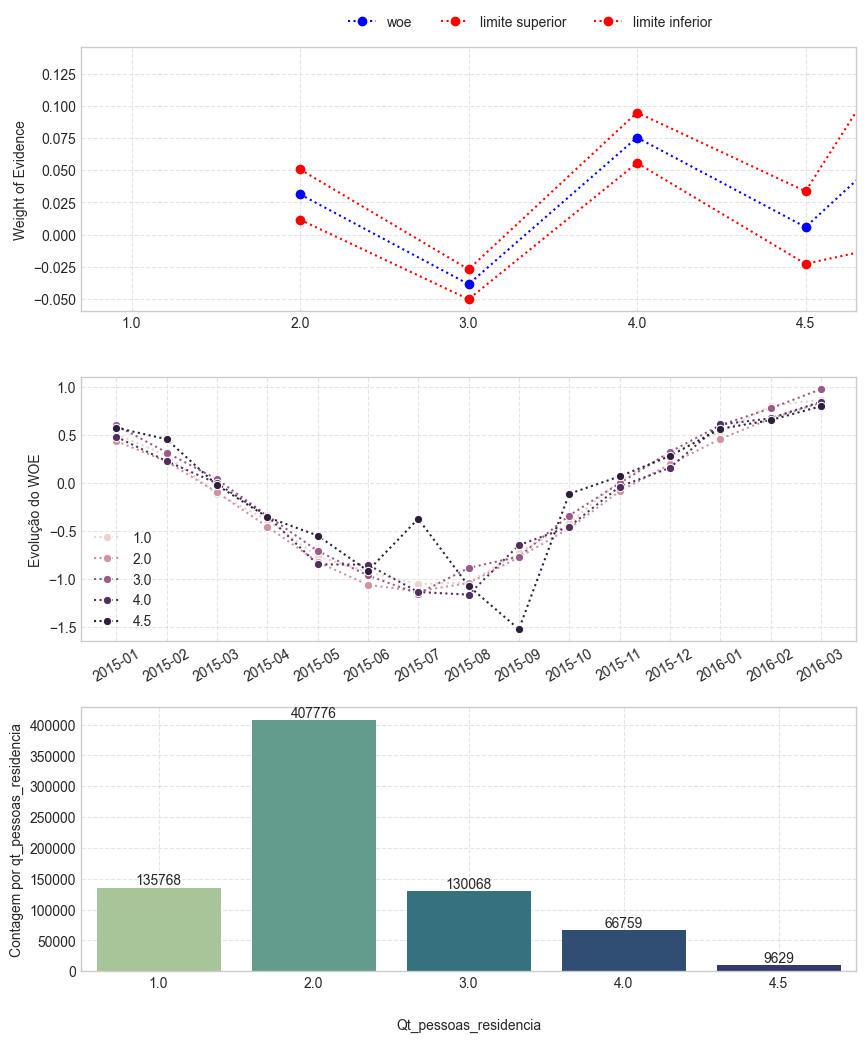

In [54]:
woe_discreta(df2, 'qt_pessoas_residencia')

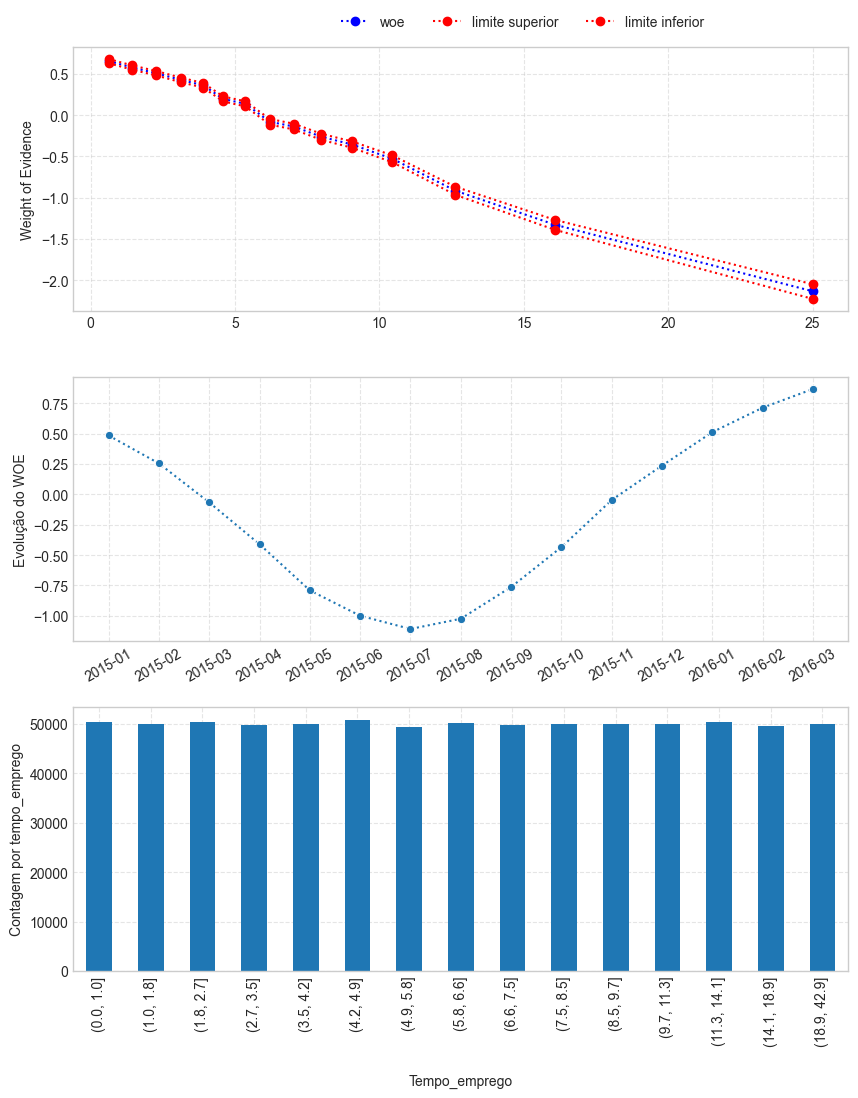

In [55]:
woe_continua(df2, 'tempo_emprego', 15)

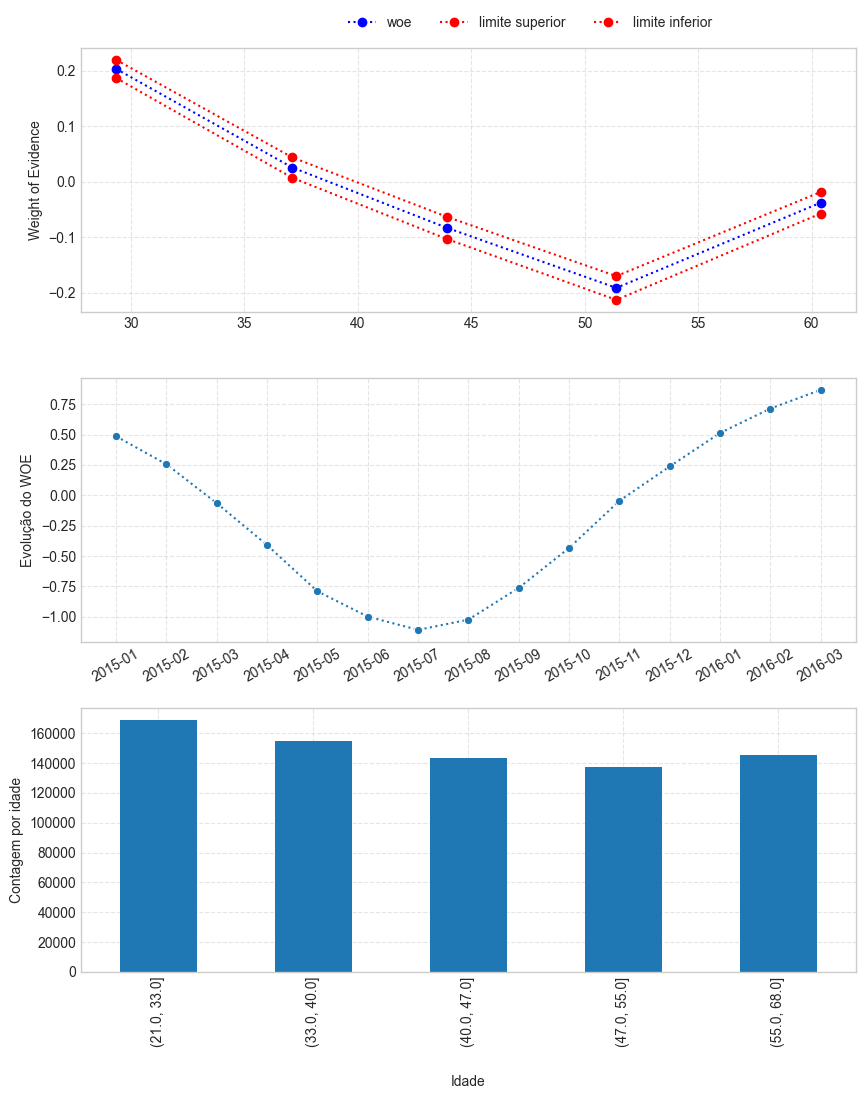

In [56]:
woe_continua(df, 'idade', 5)

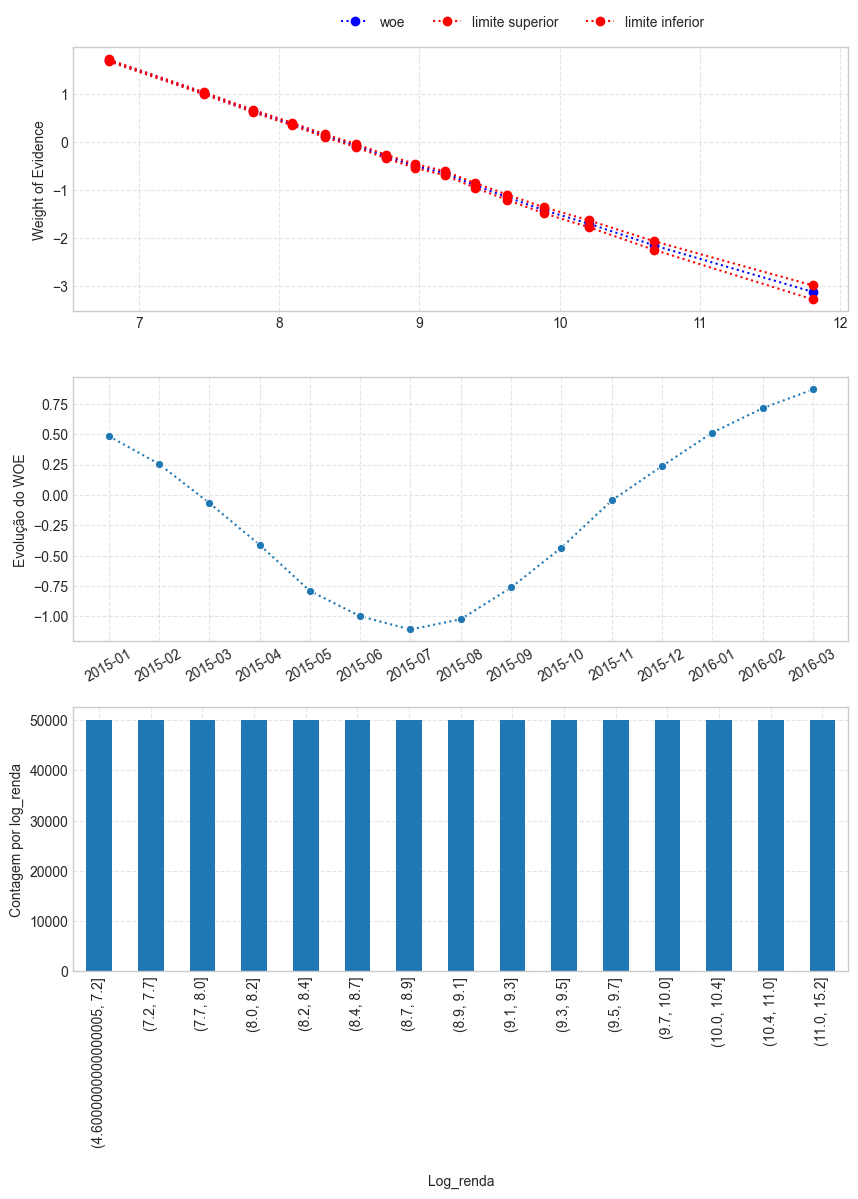

In [57]:
woe_continua(df, 'log_renda', 15)

In [58]:
metadados = pd.DataFrame({'dtype':df2.drop(columns=['data_ref', 'mes', 'bom', 'index']).dtypes})
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados['nunique'] = df2.nunique()
metadados['nmissing'] = df2.isna().sum()
for var in metadados[metadados.papel=='covariavel'].index:
    metadados.loc[var, 'IV'] = IV(df2, var, 'mau')
    
metadados.sort_values(by='IV', ascending=False)

dtype       papel  nunique  nmissing        IV
renda                  float64  covariavel   142419         0  1.163447
log_renda              float64  covariavel   140208         0  1.163447
tempo_emprego          float64  covariavel    26982         0  0.377504
idade                    int64  covariavel       47         0  0.020753
posse_de_imovel           bool  covariavel        2         0  0.009693
tipo_renda              object  covariavel        4         0  0.009315
educacao                object  covariavel        2         0  0.003255
tipo_residencia         object  covariavel        3         0  0.002802
sexo                    object  covariavel        2         0  0.002185
qt_pessoas_residencia  float64  covariavel        5         0  0.002054
qtd_filhos             float64  covariavel        4         0  0.001209
estado_civil            object  covariavel        5         0  0.001126
posse_de_veiculo          bool  covariavel        2         0  0.000108
mau                       bool    resposta        2         0       NaN

As variáveis `renda` e `log_renda` possuem o mesmo IV. Como a transformação mantém o poder preditivo da variável e a distribuição se aproxima melhor de uma normal, torna a utilização da mesma mais vantajoso.

In [59]:
df2[['posse_de_veiculo', 'posse_de_imovel', 'mau']] = df2[['posse_de_veiculo', 'posse_de_imovel', 'mau']].astype(int)
df2['sexo'] = df2['sexo'].map({'F': 1, 'M': 0})

Separação em treino e validação *Out of time*:

In [60]:
data_final = df2.data_ref.max()
data_inicio = data_final - pd.DateOffset(months=3)

validacao = df2[df2.data_ref >= data_inicio]
treino = df2[df2.data_ref < data_inicio]

Modelo treinado com todas as variáveis apenas com o tratamento feito anteriormente:

In [61]:
formula = ''' mau ~ 
            renda + 
            tempo_emprego + 
            idade + 
            posse_de_imovel + 
            tipo_renda + 
            educacao + 
            tipo_residencia + 
            sexo +
            qt_pessoas_residencia +
            qtd_filhos +
            estado_civil +
            posse_de_veiculo
        '''
rl = smf.glm(formula, data=treino, family=sm.families.Binomial()).fit()
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549981
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1003e+05
Date:                qua, 06 ago 2025   Deviance:                   2.1995e+05
Time:                        15:51:57   Pearson chi2:                 9.38e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04076
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.6079      0.192     -8.383      0.000      -1.984      -1.232
tipo_renda[T.Empresário]                        -0.0536      0.015     -3.585      0.000      -0.083      -0.024
tipo_renda[T.Pensionista]                       -0.0776      0.021     -3.639      0.000      -0.119      -0.036
tipo_renda[T.Servidor público/Bolsista]         -0.0464      0.025     -1.866      0.062      -0.095       0.002
educacao[T.Superior/Pos]                        -0.0531      0.014     -3.798      0.000      -0.081      -0.026
tipo_residencia[T.Comunitario/Governamental]    -0.0126      0.031     -0.402      0.688      -0.074       0.049
tipo_residencia[T.Pais/Aluguel]                  0.0299      0.024      1.255      0.210      -0.017       0.077
estado_civil[T.Separado]                        -0.0149      0.097     -0.153      0.878      -0.205       0.176
estado_civil[T.Solteiro]                        -0.0322      0.096     -0.338      0.736      -0.219       0.155
estado_civil[T.União]                            0.0543      0.022      2.497      0.013       0.012       0.097
estado_civil[T.Viúvo]                           -0.0749      0.099     -0.754      0.451      -0.270       0.120
renda                                        -9.572e-05   1.13e-06    -84.750      0.000   -9.79e-05   -9.35e-05
tempo_emprego                                   -0.0259      0.002    -14.173      0.000      -0.030      -0.022
idade                                            0.0009      0.001      1.165      0.244      -0.001       0.002
posse_de_imovel                                 -0.0911      0.013     -7.199      0.000      -0.116      -0.066
sexo                                             0.1159      0.014      8.264      0.000       0.088       0.143
qt_pessoas_residencia                           -0.0430      0.094     -0.455      0.649      -0.228       0.142
qtd_filhos                                       0.0504      0.095      0.531      0.596      -0.136       0.237
posse_de_veiculo                                 0.0316      0.013      2.390      0.017       0.006       0.058
================================================================================================================
"""

Podemos notar que a variável `renda` apresenta coeficicentes muito distante das outras variáveis. Para melhorar essa relação vamos utilizar a variável `log_renda`.

Vamos também selecionar as variáveis com os maiores valores de IV e aquelas com o p-value significante:

In [62]:
formula_final = '''mau ~ 
                    log_renda + 
                    tempo_emprego + 
                    idade + 
                    posse_de_imovel + 
                    tipo_renda + 
                    educacao
                '''
rl_final = smf.glm(formula_final, data=treino, family=sm.families.Binomial()).fit()
rl_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               550000
Model:                            GLM   Df Residuals:                   549991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0609e+05
Date:                qua, 06 ago 2025   Deviance:                   2.1218e+05
Time:                        15:52:11   Pearson chi2:                 5.43e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05440
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   5.8796      0.062     95.150      0.000       5.758       6.001
tipo_renda[T.Empresário]                   -0.0024      0.015     -0.159      0.874      -0.032       0.027
tipo_renda[T.Pensionista]                  -0.0136      0.021     -0.637      0.524      -0.055       0.028
tipo_renda[T.Servidor público/Bolsista]    -0.0164      0.025     -0.651      0.515      -0.066       0.033
educacao[T.Superior/Pos]                   -0.0019      0.014     -0.137      0.891      -0.030       0.026
log_renda                                  -0.9865      0.007   -136.279      0.000      -1.001      -0.972
tempo_emprego                              -0.0015      0.002     -0.842      0.400      -0.005       0.002
idade                                       0.0008      0.001      1.200      0.230      -0.001       0.002
posse_de_imovel                            -0.0220      0.013     -1.736      0.083      -0.047       0.003
===========================================================================================================
"""

Na presença de `log_renda` as categorias exibem um p-value mais elevado quando comparado ao modelo inicial, mas quando analisada as outras métricas do modelo nota-se uma melhora.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [63]:
modelos_dict = {
    "Modelo Inicial": rl,
    "Modelo final": rl_final
}

comparacao_treino = comparar_modelos(modelos_dict, treino)

In [64]:
modelos_dict = {
    "Modelo Inicial": rl,
    "Modelo final": rl_final
}

comparacao_validacao = comparar_modelos(modelos_dict, validacao)

In [65]:
comparacao_treino

In [66]:
comparacao_validacao

In [67]:
avaliar_modelo(rl_final, validacao, nome_modelo='Modelo Final')

Modelo      Modelo Final
AIC        212194.851072
Pseudo R²       0.126632
AUC             0.744587
KS              0.354927
Gini            0.489173
Acurácia        0.866890

### Conclusão Final

Após comparar o modelo inicial com o modelo final, observamos uma melhora clara na performance preditiva e estatística do modelo final, tanto no conjunto de treino quanto na validação.

#### Qualidade Estatística
- O **AIC** do modelo final foi menor, indicando melhor equilíbrio entre ajuste e complexidade.
- O **Pseudo R²** aumentou de 9,46% para 12,66%, mostrando maior capacidade de explicação da variabilidade dos dados.

#### Capacidade de Discriminação
- **AUC** subiu de 73,02% para 74,46% na validação, indicando melhor distinção entre classes.
- **KS** foi de 33,80% para 35,49%, superando o mínimo recomendado de 30%, o que mostra boa separação entre eventos e não eventos.

#### Estabilidade do Modelo
- O modelo final teve desempenho estável entre treino e validação, sem sinais de overfitting.

#### Outras Métricas
- O **Gini** aumentou, reforçando a capacidade de ranqueamento.
- A **acurácia** manteve-se estável (~86,6%), mas foi complementada por métricas mais robustas para avaliar o modelo.

---

#### Conclusão Geral

O modelo final é superior ao modelo inicial em todas as métricas relevantes. Ele apresenta melhor ajuste, maior poder preditivo e boa estabilidade, sendo uma solução robusta e adequada para aplicações em classificação binária, como risco de crédito.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [54]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

data_ref  index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733    F                N               N           0   
1 2015-01-01    727    F                S               S           0   
2 2015-01-01   6374    F                N               N           2   
3 2015-01-01   9566    F                N               N           0   
4 2015-01-01   9502    F                S               N           0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda    mau  
0       6.873973                    1.0   2515.39  False  
1       4.526027                    2.0   3180.19  False  
2       0.243836                    4.0   1582.29  False  
3      12.772603                    2.0  13721.17  False  
4       8.432877                    1.0   2891.08  False

In [55]:
df['posse_de_veiculo'] = df['posse_de_veiculo'].map({'S': 1, 'N': 0})
df['posse_de_imovel'] = df['posse_de_imovel'].map({'S': 1, 'N': 0})
df['mau'] = df['mau'].astype(int)
df['qtd_filhos'] = df['qtd_filhos'].astype(float)
df['sexo'] = df['sexo'].map({'F': 1, 'M': 0})
df.head()

data_ref  index  sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  \
0 2015-01-01   5733     1                 0                0         0.0   
1 2015-01-01    727     1                 1                1         0.0   
2 2015-01-01   6374     1                 0                0         2.0   
3 2015-01-01   9566     1                 0                0         0.0   
4 2015-01-01   9502     1                 1                0         0.0   

    tipo_renda             educacao estado_civil tipo_residencia  idade  \
0   Empresário                Médio     Solteiro            Casa     43   
1  Assalariado                Médio       Casado            Casa     35   
2  Assalariado                Médio       Casado            Casa     31   
3  Assalariado                Médio       Casado            Casa     54   
4  Assalariado  Superior incompleto     Solteiro            Casa     31   

   tempo_emprego  qt_pessoas_residencia     renda  mau  
0       6.873973                    1.0   2515.39    0  
1       4.526027                    2.0   3180.19    0  
2       0.243836                    4.0   1582.29    0  
3      12.772603                    2.0  13721.17    0  
4       8.432877                    1.0   2891.08    0

In [ ]:
def preencher_missing_modelo(df: pd.DataFrame, drop_cols=None, target_cols_dtype_map=None) -> pd.DataFrame:
    '''
    Preenche variáveis com valores faltantes usando modelos de Decision Tree 
    para regressão (variáveis numéricas) ou classificação (variáveis categóricas).
    
    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame original com valores faltantes.
    
    drop_cols : list, opcional
        Colunas que devem ser removidas antes do treinamento dos modelos (ex: 'data_ref', 'index').
    
    target_cols_dtype_map : dict, opcional
        Dicionário para forçar o tipo de variável (por exemplo: {'sexo': 'categorical', 'tempo_emprego': 'numeric'}).
    
    Retorna:
    --------
    df : pd.DataFrame
        DataFrame com os valores faltantes preenchidos.
    '''

    df = df.copy()
    drop_cols = drop_cols or []
    target_cols_dtype_map = target_cols_dtype_map or {}

    variaveis = df.columns.to_list()

    for var in variaveis:
        if df[var].isnull().any():
            print(f'\n🚨 Variável com missing: {var}')
            
            tipo = target_cols_dtype_map.get(var, 'numeric' if pd.api.types.is_numeric_dtype(df[var]) else 'categorical')
            print(f'Tipo detectado: {tipo}')
            
            df_modelo = df.drop(columns=drop_cols)
            df_modelo = pd.get_dummies(df_modelo, drop_first=True)

            df_completo = df_modelo[df[var].notnull()]
            df_faltante = df_modelo[df[var].isnull()]

            if df_completo.shape[0] == 0 or df_faltante.shape[0] == 0:
                print(f'⚠️ Não há dados suficientes para treinar ou prever para {var}')
                continue

            X_treino = df_completo.drop(columns=[var])
            y_treino = df_completo[var]
            X_teste = df_faltante.drop(columns=[var])

            if tipo == 'numeric':
                modelo_base = DecisionTreeRegressor(random_state=23)
            else:
                modelo_base = DecisionTreeClassifier(random_state=23)

            seletor = SelectFromModel(estimator=modelo_base, threshold='median')
            seletor.fit(X_treino, y_treino)

            X_treino_sel = seletor.transform(X_treino)
            X_teste_sel = seletor.transform(X_teste)

            if tipo == 'numeric':
                modelo_final = DecisionTreeRegressor(random_state=23)
            else:
                modelo_final = DecisionTreeClassifier(random_state=23)

            modelo_final.fit(X_treino_sel, y_treino)
            y_pred = modelo_final.predict(X_teste_sel)

            df.loc[df[var].isnull(), var] = y_pred

            print(f"✅ Valores faltantes de '{var}' preenchidos com Decision Tree.")

    return df

In [60]:
df_tratado = preencher_missing_modelo(df, drop_cols=['data_ref', 'index'])


🚨 Variável com missing: tempo_emprego
Tipo detectado: numeric
✅ Valores faltantes de 'tempo_emprego' preenchidos com Decision Tree.


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [ ]:
def cap_outliers_auto_iqr(data: pd.DataFrame, n_cat: int = 2, skew_threshold: float = 2.5, drop_cols: list = [],verbose=True) -> pd.DataFrame:
    '''
    Aplica capping de outliers com base no IQR para todas as variáveis numéricas,
    excluindo as que apresentam skewness alta.

    Parâmetros:
    -----------
    data : pd.DataFrame
        DataFrame com os dados.
    
    skew_threshold : float, padrão=2.0
        Valor limite de skewness para excluir variáveis muito assimétricas.
    
    verbose : bool, padrão=True
        Se True, imprime as variáveis tratadas e ignoradas.

    Retorna:
    --------
    pd.DataFrame com outliers tratados nas colunas apropriadas.
    '''

    data = data.copy()
    colunas = [col for col in data.columns if data[col].nunique() > n_cat]
    colunas_numericas = data[colunas].select_dtypes(include='number').columns
    cols_to_treat = [col for col in colunas_numericas if col not in drop_cols]

    for col in cols_to_treat:
        skewn = skew(data[col])

        if abs(skewn) > skew_threshold:
            if verbose:
                print(f"⚠️ '{col}' ignorada por skew alto ({skewn:.2f})")
            continue

        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        data[col] = data[col].clip(lower=limite_inferior, upper=limite_superior)

        if verbose:
            print(f"✅ Capping aplicado em '{col}' (skew = {skewn:.2f})")

    return data

In [62]:
df_tratado = cap_outliers_auto_iqr(df_tratado, drop_cols=['index', 'tempo_emprego'])

✅ Capping aplicado em 'qtd_filhos' (skew = 2.31)
✅ Capping aplicado em 'idade' (skew = 0.18)
✅ Capping aplicado em 'qt_pessoas_residencia' (skew = 1.19)
⚠️ 'renda' ignorada por skew alto (17.01)


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [ ]:
df_dummies = pd.get_dummies(df_tratado, drop_first=True)
X = df_dummies.drop(columns=['mau', 'data_ref', 'index'])
y = df_dummies['mau']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

model = RandomForestClassifier(n_estimators=50, random_state=23)
model.fit(X_scaled, y)

RandomForestClassifier(n_estimators=50, random_state=23)

In [ ]:
importances = pd.Series(model.feature_importances_, index=X_scaled.columns)
importances = importances.sort_values(ascending=False)

print('Top 20 variáveis mais importantes:\n')
print(importances.head(20)) 

selected_features = importances[importances > 0.0077].index.tolist()
print('\nVariáveis selecionadas (importância > 0.0077):')
print(selected_features)

Top 20 variáveis mais importantes:

renda                            0.701971
tempo_emprego                    0.124894
idade                            0.081044
qt_pessoas_residencia            0.011391
posse_de_veiculo                 0.009479
qtd_filhos                       0.007992
posse_de_imovel                  0.007725
tipo_renda_Empresário            0.007697
sexo                             0.007201
estado_civil_União               0.005170
educacao_Médio                   0.004550
estado_civil_Solteiro            0.004257
tipo_renda_Pensionista           0.004181
educacao_Superior completo       0.003949
tipo_renda_Servidor público      0.003493
tipo_residencia_Casa             0.003327
estado_civil_Separado            0.003152
educacao_Superior incompleto     0.001980
tipo_residencia_Governamental    0.001833
estado_civil_Viúvo               0.001758
dtype: float64

Variáveis selecionadas (importância > 0.0077):
['renda', 'tempo_emprego', 'idade', 'qt_pessoas_residencia', 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [80]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled[selected_features])

In [81]:
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df

PC1       PC2       PC3       PC4       PC5
0       1.144433 -0.799921  1.342698 -1.005657  0.204090
1      -0.200778 -0.757608 -0.025299  1.483660  0.682227
2      -3.263535  0.010435  0.493418 -1.827519 -0.172898
3       1.102099  0.254941  1.026435 -1.112316 -0.930740
4       0.297035 -0.782146  2.197322  0.883544  0.586993
...          ...       ...       ...       ...       ...
749995  0.686231 -0.766194 -0.902432 -0.407128  0.224228
749996  1.946659 -1.166394 -1.149224 -0.305525 -0.629948
749997 -2.913893  1.060136  0.942980  0.054793 -1.670292
749998  2.013918  0.096958 -0.723750 -0.270589 -0.279354
749999 -2.905956  1.091795  0.948395  0.059463 -1.651563

[750000 rows x 5 columns]

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [85]:
df_dummies = pd.get_dummies(df_tratado.drop(columns=['data_ref', 'index']), drop_first=True)
df_dummies.columns = [unidecode(c).lower().replace(' ', '_') for c in df_dummies.columns]
df_dummies.head()

sexo  posse_de_veiculo  posse_de_imovel  qtd_filhos  idade  tempo_emprego  \
0     1                 0                0         0.0     43       6.873973   
1     1                 1                1         0.0     35       4.526027   
2     1                 0                0         2.0     31       0.243836   
3     1                 0                0         0.0     54      12.772603   
4     1                 1                0         0.0     31       8.432877   

   qt_pessoas_residencia     renda  mau  tipo_renda_bolsista  ...  \
0                    1.0   2515.39    0                False  ...   
1                    2.0   3180.19    0                False  ...   
2                    4.0   1582.29    0                False  ...   
3                    2.0  13721.17    0                False  ...   
4                    1.0   2891.08    0                False  ...   

   educacao_superior_incompleto  estado_civil_separado  estado_civil_solteiro  \
0                         False                  False                   True   
1                         False                  False                  False   
2                         False                  False                  False   
3                         False                  False                  False   
4                          True                  False                   True   

   estado_civil_uniao  estado_civil_viuvo  tipo_residencia_casa  \
0               False               False                  True   
1               False               False                  True   
2               False               False                  True   
3               False               False                  True   
4               False               False                  True   

   tipo_residencia_com_os_pais  tipo_residencia_comunitario  \
0                        False                        False   
1                        False                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   

   tipo_residencia_estudio  tipo_residencia_governamental  
0                    False                          False  
1                    False                          False  
2                    False                          False  
3                    False                          False  
4                    False                          False  

[5 rows x 26 columns]

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.drop(columns=['data_ref', 'index'], inplace=True)


X = df.drop(columns=['mau'])
y = df['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

cat_cols = list(X_train.select_dtypes('object').columns)
num_cols = list(X_train.select_dtypes(exclude='object').columns)

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=1.5, skew_threshold=2.5, drop_cols=None):
        '''
        multiplier: multiplicador do IQR para definir limites.
        skew_threshold: se definido, ignora colunas com skewness absoluto acima deste valor.
        drop_cols: lista de colunas para não aplicar a remoção de outliers.
        '''
        self.multiplier = multiplier
        self.skew_threshold = skew_threshold
        self.drop_cols = drop_cols if drop_cols is not None else []

    def fit(self, X, y=None):
        self.cols_ = [col for col in X.columns if col not in self.drop_cols]
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols_:
            if pd.api.types.is_numeric_dtype(X[col]):
                
                if self.skew_threshold is not None:
                    skew_value = X[col].skew()
                    if abs(skew_value) > self.skew_threshold:
                        continue
                
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.multiplier * IQR
                upper_bound = Q3 + self.multiplier * IQR
                
                X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)
        
        return X

In [18]:
impt_num = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=23)
impt_cat = SimpleImputer(strategy='most_frequent')

outlier = OutlierRemover(skew_threshold=2.5, drop_cols=['tempo_emprego'])

dummies = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

feature_select = SelectKBest(score_func=mutual_info_classif, k=7)


In [19]:
num_pipeline = Pipeline(steps=[
    ('outlier', outlier),
    ('imputer', impt_num),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', impt_cat),
    ('onehot', dummies)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_select),
    ('pca', PCA(n_components=5))
])

In [20]:
return_train = pipeline.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(return_train, columns=[f'PC{i+1}' for i in range(pipeline.named_steps['pca'].n_components_)])
X_train_transformed

PC1       PC2       PC3       PC4       PC5
0      -0.915589  0.110698 -0.169901 -0.124672  0.586793
1      -0.567125 -0.658682 -0.239229  0.388712  0.484817
2      -0.606797  0.212005 -0.445734 -0.380513 -0.278384
3      -0.606797  0.212005 -0.445734 -0.380513 -0.278384
4      -0.606797  0.212005 -0.445734 -0.380513 -0.278384
...          ...       ...       ...       ...       ...
524995  0.460543 -0.740052  0.300080 -0.388277 -0.216261
524996  0.748416  0.335458  0.336472 -0.941678  0.126975
524997 -0.258333 -0.557375 -0.515062  0.132871 -0.380359
524998  0.893449  0.770982  0.907005 -0.278887 -0.099859
524999 -0.279252  0.416828 -0.202838 -0.164688  0.828053

[525000 rows x 5 columns]

In [21]:
return_test = pipeline.transform(X_test)
X_test_transformed = pd.DataFrame(return_test, columns=[f'PC{i+1}' for i in range(pipeline.named_steps['pca'].n_components_)])
X_test_transformed

PC1       PC2       PC3       PC4       PC5
0      -0.606797  0.212005 -0.445734 -0.380513 -0.278384
1      -0.035328 -0.286670  0.727055  0.486741 -0.769905
2       1.018907 -0.269104 -0.404440 -0.119372  0.187712
3       0.029540  0.518135 -0.478671 -0.420530 -0.037123
4      -0.567125 -0.658682 -0.239229  0.388712  0.484817
...          ...       ...       ...       ...       ...
224995  0.029540  0.518135 -0.478671 -0.420530 -0.037123
224996 -0.152475  0.190428  0.653538 -0.525513  0.669002
224997  0.341022 -0.143429  1.154744  0.650662  0.340192
224998  0.208307  0.526434  0.755149 -0.186967 -0.344780
224999 -0.788812 -0.115702  0.686475 -0.485497  0.427741

[225000 rows x 5 columns]

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [22]:
from pycaret.classification import *

df = pd.read_feather('credit_scoring.ftr')
df.drop(columns=['data_ref', 'index'], inplace=True)
df.head()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                N               N           0   Empresário   
1    F                S               S           0  Assalariado   
2    F                N               N           2  Assalariado   
3    F                N               N           0  Assalariado   
4    F                S               N           0  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                Médio     Solteiro            Casa     43       6.873973   
1                Médio       Casado            Casa     35       4.526027   
2                Médio       Casado            Casa     31       0.243836   
3                Médio       Casado            Casa     54      12.772603   
4  Superior incompleto     Solteiro            Casa     31       8.432877   

   qt_pessoas_residencia     renda    mau  
0                    1.0   2515.39  False  
1                    2.0   3180.19  False  
2                    4.0   1582.29  False  
3                    2.0  13721.17  False  
4                    1.0   2891.08  False

In [ ]:
data = df.sample(frac=0.95, random_state=23)
data_val = df.drop(data.index)
data.reset_index(inplace=True, drop=True)

data.shape[0], data_val.shape[0]

(712500, 37500)

In [24]:
lr_exp = setup(data=data, target='mau')

In [25]:
gbm = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
gbm_tunned = tune_model(gbm)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


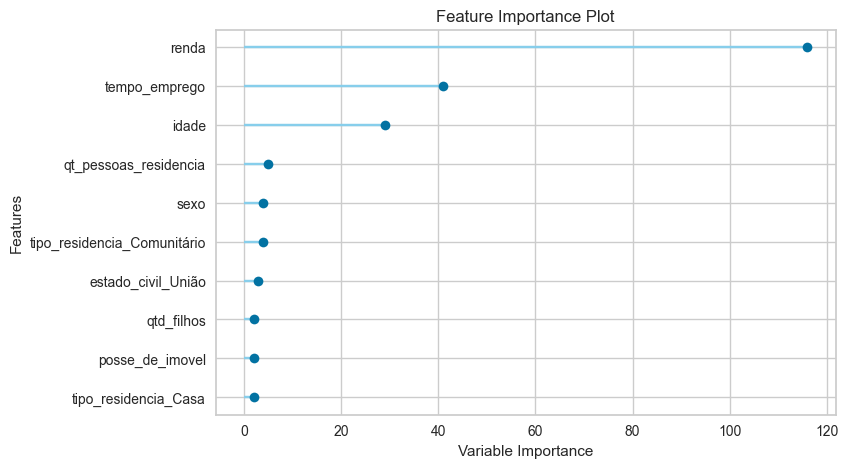

In [27]:
plot_model(gbm_tunned, plot='feature')

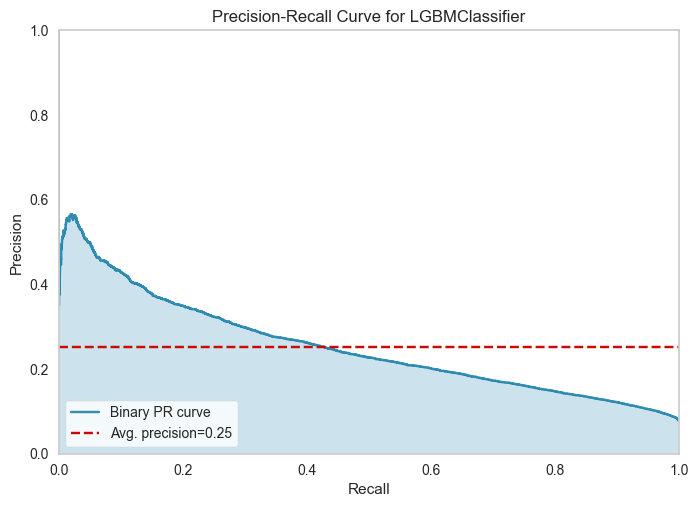

In [31]:
plot_model(gbm_tunned, plot = 'pr')

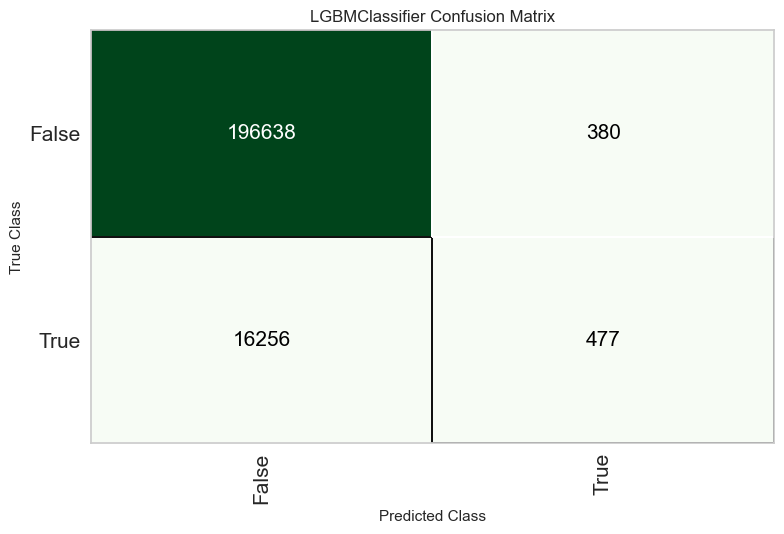

In [32]:
plot_model(gbm_tunned, plot = 'confusion_matrix')

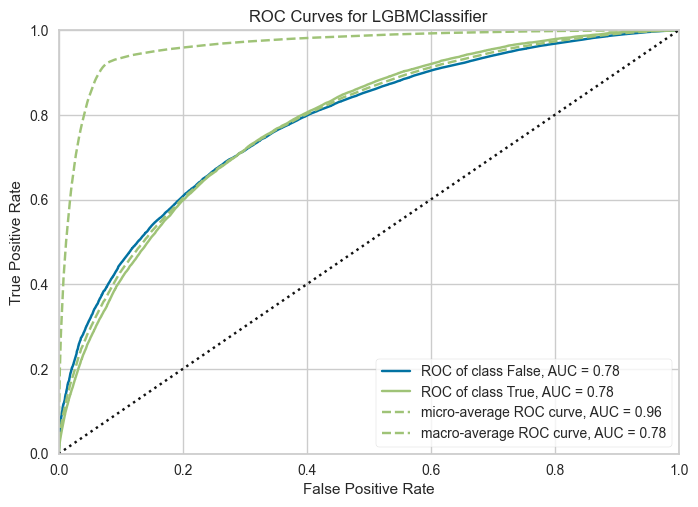

In [28]:
plot_model(gbm_tunned, plot='auc')

In [29]:
final_model = finalize_model(gbm_tunned)
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [33]:
predict_model(final_model);

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [34]:
unseen_predictions = predict_model(final_model, data=data_val)
unseen_predictions.head()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
5     F                N               S           1  Assalariado   
15    M                N               S           0  Assalariado   
37    F                N               N           0  Pensionista   
56    F                N               N           0   Empresário   
59    M                S               S           0  Pensionista   

             educacao estado_civil tipo_residencia  idade  tempo_emprego  \
5   Superior completo       Casado            Casa     45      24.315069   
15              Médio       Casado            Casa     47      12.931507   
37              Médio     Separado            Casa     64            NaN   
56              Médio       Casado            Casa     37      11.046576   
59  Superior completo       Casado            Casa     66            NaN   

    qt_pessoas_residencia         renda    mau  prediction_label  \
5                     3.0  25387.160156  False                 0   
15                    2.0   8138.240234  False                 0   
37                    1.0   1872.829956  False                 0   
56                    2.0  18307.279297  False                 0   
59                    2.0   1406.449951  False                 0   

    prediction_score  
5             0.9863  
15            0.9524  
37            0.8095  
56            0.9774  
59            0.8015

In [ ]:
save_model(final_model, 'model_final_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            